In [2]:
import pyfits
import os
import pyfits
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from astropy.cosmology import WMAP9 as cosmo
import matplotlib
import math
from scipy import ndimage
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.ndimage import iterate_structure
from scipy.ndimage.filters import maximum_filter
import scipy.optimize as opt
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from astropy.io import fits
import math
import photutils
import statmorph
from skimage import measure

'''imports a million things'''
import pyfits
from photutils import CircularAperture,aperture_photometry

print(os.getcwd())
im10 = pyfits.open('stellar_kinematics_noise_included_fg3_m12_iso1_200_1.fits')
im1 = pyfits.open('stellar_kinematics_noise_excluded_fg3_m12_iso1_200_1.fits')

/Users/beckynevin/Documents/Backup_My_Book/My_Passport_backup/Kinematics


-- --


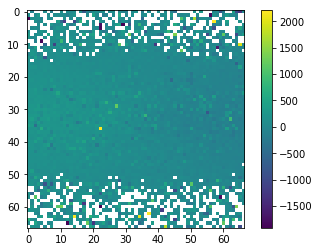

-1914.7353309746056 2207.2402936140597
(array([ 2,  4, 60, 65]), array([ 0, 29, 22, 12]))
144.37963922339372 2.472363297397755
[[1665 1153 1153 ... 1025 1537 1537]
 [ 129  129  129 ...  513    0  513]
 [1665 1153 1665 ... 1537 1025 1025]
 ...
 [1153 1153 1665 ... 1537 1025 1025]
 [ 129  129  129 ...  513    0  513]
 [1665 1153 1665 ... 1025 1537 1537]]


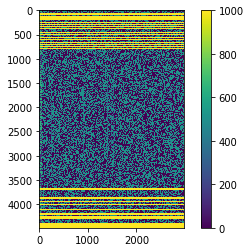

In [3]:
kin10 = ma.masked_where(im10[2].data==0,im10[1].data)
kin1 = im1[1].data

kin10_err = ma.masked_where(im10[2].data==0,im10[2].data)




#kin10 = ma.masked_where(im10[4].data==0, kin10)

#kin10 = ma.masked_where(kin10< -1000, kin10)
print(kin10[0,0], kin10_err[0,0])
import matplotlib.pyplot as plt
plt.clf()
plt.imshow(kin10)#,vmin=-50, vmax=50 )
plt.colorbar()
plt.show()

print(np.min(kin10), np.max(kin10))
print(np.where(kin10 == kin10.min()))
print(kin10[49,5], kin10_err[49,5])

kin_mask=im10[5].data
print(kin_mask)
plt.imshow(kin_mask, vmax=1000)
plt.colorbar()
plt.show()

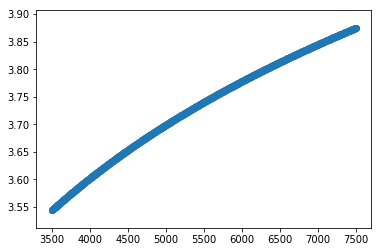

In [4]:
lambdas = np.linspace(3500,7500,1000)
ys = [math.log10(x) for x in lambdas]
plt.scatter(lambdas, ys)
plt.show()

In [15]:
def convolve_spatially(input_data,factor, plot):
    if ((len(input_data[:,0])/factor).is_integer()):
        length=int(len(input_data[:,0])/factor)
    else:
        stop


    data_new = np.zeros(( length, length))

    data_new += input_data[ ::factor, ::factor] + input_data[ 1::factor, ::factor] + input_data[ ::factor, 1::factor] + input_data[ 1::factor, 1::factor]# Take (0,0)                                                                                                               \
                                                                                                                                                

    return data_new
def get_center_kin(view,myr, broadband):
    '''We need to take the r-band image and find the brightest 25% of the pixels'''
    plt.imshow(broadband)
    plt.show()
    sort_list=np.sort(broadband, axis=None)     # sort the flattened array
    #print('sort list', sort_list)
    
    '''Go through and pull out all the unmasked elements of the sorted list'''
    sort_list_real=[]
    for i in range(len(sort_list)):
        if math.isnan(sort_list[i]):
            continue
        else:
            sort_list_real.append(sort_list[i])
    sort_list_real=np.array(sort_list_real)
    '''Sorts in increasing order, make a cutoff for the top 25% of pixels and mask'''
    value = (sort_list_real[int(len(sort_list_real)*0.75)])
    max_filter=ma.masked_where(broadband < value, broadband)
    
    
    '''Now calculate a weighted average of x and y pos'''
    #weighted_avg = np.average(rate, weights=amount)
    xs=[]
    ys=[]
    weight=[]
    for i in range(np.shape(max_filter)[0]):
        for j in range(np.shape(max_filter)[1]):
            
            if ma.is_masked(max_filter[i][j]):
                continue
            else:
                xs.append(i)
                ys.append(j)
                weight.append(max_filter[i][j])
    #print('weight', weight)
    avg_x=np.average(xs, weights=weight)
    avg_y=np.average(ys, weights=weight)
    '''print('avg_x', avg_x, 'avg_y', avg_y)
    
    plt.imshow(max_filter,norm=matplotlib.colors.LogNorm())
    plt.title('Max filter')
    plt.scatter(avg_x, avg_y, color='r')
    #plt.colorbar()
    plt.show()'''
            
    return avg_x, avg_y

def fit_2_gaussian(x_1,y_1,x_2,y_2, data):
    # Create x and y indices
    data=np.flipud(data)
    x = np.linspace(0, 299, 300)
    y = np.linspace(0, 299, 300)
    x, y = np.meshgrid(x, y)
    

    # add some noise to the data and try to fit the data generated beforehand
    initial_guess = (20,x_1,y_1,7,7,0,10,20,x_2,y_2,7,7,0)#these are good guesses for the units of surface brightness
    data=data.ravel()
    
   
    
    try:
        popt, pcov = opt.curve_fit(twoD_two_Gaussian, (x, y), data, p0=initial_guess)
        fit='yes'
    except RuntimeError:
        popt=[0,0,0,0,0,0,0,0,0,0,0,0,0]
        fit='no'
        #flag for if the fit failed
 
    
    return popt[1], popt[2], popt[8], popt[9], popt[0], popt[7], np.sqrt(popt[3]**2+popt[4]**2), np.sqrt(popt[10]**2+popt[11]**2), fit 

def twoD_two_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset,
                     amplitude_2, xo_2, yo_2, sigma_x_2, sigma_y_2, theta_2):
    (x, y) = xdata_tuple 
    xo = float(xo)
    yo = float(yo)   
    xo_2 = float(xo_2)
    yo_2 = float(yo_2)  
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    
    a_2 = (np.cos(theta_2)**2)/(2*sigma_x_2**2) + (np.sin(theta_2)**2)/(2*sigma_y_2**2)
    b_2 = -(np.sin(2*theta_2))/(4*sigma_x_2**2) + (np.sin(2*theta_2))/(4*sigma_y_2**2)
    c_2 = (np.sin(theta_2)**2)/(2*sigma_x_2**2) + (np.cos(theta_2)**2)/(2*sigma_y_2**2)
    
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))+ amplitude_2*np.exp( - (a_2*((x-xo_2)**2) + 2*b_2*(x-xo_2)*(y-yo_2) 
                            + c_2*((y-yo_2)**2)))
    
    return g.ravel()
def detect_peaks(image):
    """
    Takes an image and detect the peaks using the local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """

    # define an 8-connected neighborhood
    struct = generate_binary_structure(2,1)
    
    neighborhood = iterate_structure(struct, 10).astype(bool)
    
    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.
    
    
    #we create the mask of the background
    background = (image==0)

    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    detected_peaks = local_max ^ eroded_background

    return detected_peaks
def determine_coords(img):
    
    '''Apply a 10x10 kernal to the image to filter out noise (its basically a low pass filter)
    to smooth things out'''
    kernel = np.ones((10,10))
    

    lp = ndimage.convolve(img, kernel)#was result
    
    
    '''Okay here is where you can filter out the really low stuff
    (anything below 20% of the max is eliminated so that we can detect the peak pixel)'''
    
    max_value=(lp.max())
    low = np.where(lp < 0.2*max_value)
    
   
    lp[low] = 0
    
    
    
    
    
    
    '''Detects brightest peaks in an image (can detect more than 1)'''
    indices = np.where(detect_peaks(lp) == 1)#was hp_lp_sharp
    
    number_of_sols=len(indices[0])
    
    
    try:
        return indices[0][0],indices[0][-1],indices[1][0],indices[1][-1], lp, number_of_sols
    except IndexError:
        #if there are no peaks this means the simulation was somehow cut off and
        #starting with returning zeros will flag the entire procedure to continue
        #without further ado
        return 0,0,0,0,lp,number_of_sols

def determine_brighter(img, x, y, x2, y2, pix, redshift):
    kpc_arcmin=cosmo.kpc_proper_per_arcmin(redshift)#insert the redshift to get the kpc/arcmin scaling

    
    ap_size=(3*(kpc_arcmin.value/60))/pix ###3 arcsec diameter * (kpc/arcsec)   / (kpc/pix) -->
    #This is now in units of pixels
    
    '''step 1: define the circular aperture'''
    positions = [(x, y), (x2, y2)]
    from photutils import CircularAperture,aperture_photometry
    apertures = CircularAperture(positions, ap_size)
    phot_table = aperture_photometry(img, apertures)
    total_light_1=phot_table['aperture_sum'][0]
    total_light_2=phot_table['aperture_sum'][1]

    
    
    masks = apertures.to_mask(method='center')
    mask = masks[0]

    image = mask.to_image(shape=((np.shape(img)[0], np.shape(img)[0])))
    skip='no'
    try:
        data_cutout = mask.apply(img)
        
    except AttributeError:#TypeError or 
        skip='yes'
    return total_light_1, total_light_2, skip


def clip_image(ins, pixelscale, redshift, xcen, ycen):

    kpc_arcmin=cosmo.kpc_proper_per_arcmin(redshift)#insert the redshift                                                                                                                                                                           
    #print(kpc_arcmin.value/60, 'kpc per arcsec')                                                                                                                                                                                                  
    '''Divide the pixelscale (kpc/pix) by kpc/arcsec to get arcsec                                                                                                                                                                                 
    size of pixels'''
    size_a=pixelscale/(kpc_arcmin.value/60)
    num_pix_half=int(17/size_a)
    '''32" per diameter is the largest IFU'''








    if xcen-num_pix_half < 0 or ycen-num_pix_half < 0 or xcen+num_pix_half > 300 or ycen+num_pix_half > 300:
        print('Outside of the box')
        clipped=0
        tag='no'

    else:
        #build clipped and centered image                                                                                                                                                                                                          %%!
        clipped=(ins[xcen-num_pix_half:xcen+num_pix_half,ycen-num_pix_half:ycen+num_pix_half])
        tag='yes'



    return clipped, size_a, num_pix_half, tag, xcen, ycen
print('configured')
def get_center(view, myr, run, image, pixelscale, z):
    
    x_cen=0
    y_cen=0
    
    
    b=determine_coords(image)
    #this determines the locations of the galaxies

    if b[0]==0:
        #if the first index from determine_coords is zero, the galaxy is out of the image
        #and we can continue and skip this particular image (sometimes other viewpoints of
        #the same snapshot are in the frame so don't get rid of an entire snapshot)
        
        return 0, 0, 1, 0







    low_pass=b[4]
    num_sol=b[5]

    '''Now, fit a couple 2D gaussians if there are 2 brightest pixels, otherwise
    fit only one 2D gaussian. The output of fit_2_gaussians will be the positions of these
    maxima'''

    if num_sol==1:
        #this is if there's only really one solution because the bulges are too close together
        #fit a 2D gaussian to center the previous guess of peak pixels using the entire surface
        #brightness profile
        c=fit_2_gaussian(b[1],np.shape(image)[0]-b[0],b[1],np.shape(image)[0]-b[0],low_pass)
        if c[8]=='no':
             c=fit_2_gaussian(b[2],np.shape(image)[0]-b[0],b[3],np.shape(image)[0]-b[1],low_pass)

    else:
        c=fit_2_gaussian(b[2],np.shape(image)[0]-b[0],b[3],np.shape(image)[0]-b[1],low_pass)



    if c[4] > c[5]:
        '''this means point 1 is brighter'''
        in_x = c[1]
        in_y = c[0]
        in_2_x = c[3]
        in_2_y = c[2]


    if c[5] > c[4]:
        '''point 2 is the brighter source'''
        in_x = c[3]
        in_y = c[2]
        in_2_x = c[1]
        in_2_y = c[0]




    '''Now place a aperture over each center and figure out which is brighter overall'''
    c_final=determine_brighter(image,  in_y,np.shape(image)[0]-in_x,  in_2_y, np.shape(image)[0]-in_2_x, pixelscale, z)

    #if c_final[2]=='yes':
    #    return 0, 0, 1, 0

    if c_final[0] > c_final[1]:
        #Clip the image in the SDSS imaging size around 
        d=clip_image(image, pixelscale, z, int(np.shape(image)[0]-in_x), int(in_y))
        #this means the first aperture (center) is indeed brighter
    else:
        d=clip_image(image, pixelscale, z, int(np.shape(image)[0]-in_2_x), int(in_2_y))

    if d[3]=='no':
        #this means the cutout is outside the image --> bad
        
        return 0, 0, 1, 0
 
    x_cen=d[4]
    y_cen=d[5]
    
    if x_cen==0 or y_cen==0:
        flag=1
    else:
        flag=0
    
    
    '''Now, trying to get the segmap to mask your kinematic map'''
    '''Now we need to clip this so that its the size of an SDSS image 
    (50" by 50" in diameter)'''
    '''You also need to use the redshift to get an accurate cutout, here its 0.03, the
    mean redshift of MaNGA'''


    '''d output is surfadef mce brightness in W/m/m^2/sr but cut'''

    '''Next, convert to this weird nanomag unit that SDSS tends to use:
    The standard source for each SDSS band is close to but not exactly 
    the AB source (3631 Jy), meaning that a nanomaggy is approximately 3.631×10-6 Jy,
    which is the conversion we use here.
    Note that nanomaggies are still a unit of surface brightness so we can use nanomaggies
    later in the code to compute the nonparametric quantities Gini, M20, C, A, and S.'''
    '''Nanomags also does a couple of important image processing steps like introduce a sky
    background that is typical for SDSS imaging as well a constructs a Poisson noise map.'''
    e=nanomags(z, pixelscale, d[0],view, myr)


    #Size is determined by what?                                                                                                                                                                                                                   
    #arc_size of                                                                                                                                                                                                                                   
    #return clipped, size_a, num_pix_half, tag, xcen, ycen                                                                                                                                                                                         
    kpc_arcmin=cosmo.kpc_proper_per_arcmin(z)
    size_a = pixelscale/(kpc_arcmin.value/60)#now we're in "/pix                                                                                                                                                                                   
    pix_size = d[2]
    size = int(pix_size*size_a) #now we're in units of " of one side of the thing                                                                                                                                                                  

    prep=convolve_rebin_image(myr,z,pixelscale,view, e, size)
    #def convolve_rebin_image(number, z, pixscale, view, counts, size):                                                                                                                                                                            
    '''The second extension here is the S_N in r-band'''
    plt.clf()

    fig=plt.figure()
    ax0=fig.add_subplot(211)
    im0=ax0.imshow(prep[0], norm=matplotlib.colors.LogNorm(), cmap='afmhot_r')
    ax0.set_title('Counts')
    plt.colorbar(im0)

    masked_S_N = ma.masked_where(prep[0] < 1, prep[1])
    g_band_signal = ma.masked_where(prep[0] < 1, prep[0])
    masked_S_N = ma.masked_where(np.abs(masked_S_N) < 1, masked_S_N)



    ax1=fig.add_subplot(212)
    im1=ax1.imshow(masked_S_N, norm=matplotlib.colors.LogNorm(), cmap='afmhot_r')
    ax1.set_title('S/N')
    plt.colorbar(im1)
    plt.savefig('S_N_g_band.png')

    return x_cen, y_cen, flag, d[2], g_band_signal, masked_S_N#g_band_signal/masked_S_N 

'''Now I have to convert the units of LAURAS sims into nanomaggies and AB mags (mags of DR7 and DR13)
'''
def nanomags(z, pixscale, camera_data, view, number):

    c = 299792.458*1000#to get into m/s                                                                                                                                                                                                            



    pixelscale=pixscale
    from astropy.cosmology import FlatLambdaCDM
    cosmo = FlatLambdaCDM(H0=70,Om0=0.3)
    d_A = cosmo.comoving_distance(z).value/(1+z)
    #here's a good review of all the different distances cosmology distances:                                                                                                                                                                      
    #http://www.astro.ufl.edu/~guzman/ast7939/projects/project01.html                                                                                                                                                                              

    #Convert from specific intensity units (W/m/m^2/sr) from SUNRISE to Janskies (W/Hz/m^2):                                                                                                                                                       
    Janskies=np.array(10**(26)*camera_data*(pixelscale/(1000*d_A))**2*np.pi*((6185.2*10**(-10))**2/c), dtype='>f4')
    #this 1.35e-6 comes from the arcsin(R_sky/Distance to object)                                                                                                                                                                                  
    #the answer needs to be in radians                                                                                                                                                                                                             

    #J=10^-26 W/m^2/Hz, so units of flux density                                                                                                                                                                                                   
    #reference site: http://www.cv.nrao.edu/course/astr534/Brightness.html                                                                                                                                                                         
    #We need to go from a spectral brightness (I_nu) which is in m units                                                                                                                                                                           
    #To a flux density (S_nu) which is in units of Janskies (W/m^2/Hz)                                                                                                                                                                             

    #So you need to multiply the Fν by c / λ^2 to convert it into Fλ.                                                                                                                                                                              
    #But we are not done yet! Recalling from above, the units of Fλ                                                                                                                                                                               
    #are not an energy density. You need to get another factor of λ                                                                                                                                                                               
    #in there to make the units work out to be energy density:                                                                                                                                                                                     
    #calculate λFλ to get units of ergs/s/cm^2.                                                                                                                                                                                                    

    Janskies_bright = Janskies*100**(1/5)

    nanomaggy=Janskies_bright/(3.631*10**(-6))


    '''Now convert into the correct background:)'''

    #nanomaggies and stuff: (Finkbeiner et al. 2004)                                                                                                                                                                                               

    '''The average background and std as well as the readnoise and gain                                                                                                                                                                            
    are from another code of mine:                                                                                                                                                                                                                 
        SDSS_noise_imaging/SDSS_r_imaging.ipynb'''

    #first, convert to counts (dn) using the average value of cimg from the SDSS frame images                                                                                                                                                      
    #dn=img/cimg+simg                                                                                                                                                                                                                              
    cimg=0.003813475#0.005005225 #nanomaggies/count                                                                                                                                                                                                
    gain=3.85#4.735                                                                                                                                                                                                                                
    darkvar=3.875#1.1966                                                                                                                                                                                                                           
    simg=63.711#121.19590411 #average background value (counts) pre background subraction (used to calculate poisson error)                                                                                                                        
    counts=(nanomaggy)/cimg#+simg                                                                                                                                                                                                                  
    '''sigma_counts=np.sqrt(counts/gain+darkvar)                                                                                                                                                                                                   
    sigma_nanomags=sigma_counts*cimg                                                                                                                                                                                                               
                                                                                                                                                                                                                                                   
    nanomag_bg = counts*cimg                                                                                                                                                                                                                       
                                                                                                                                                                                                                                                   
                                                                                                                                                                                                                                                   
    sky_resids_mine=cimg*np.random.normal(0.77, 3.73, np.shape(nanomaggy))#0.331132,5.63218,np.shape(nanomaggy))                                                                                                                                   
    sky_resids_mine_counts=np.random.normal(0.77, 3.73, np.shape(nanomaggy))#0.331132,5.63218,np.shape(nanomaggy))                                                                                                                                 
    d_image=(nanomaggy)#+sky_resids_mine                                                                                                                                                                                                           
    degraded_image=d_image                                                                                                                                                                                                                         
    degraded_image_counts=d_image/cimg#will use this one in the future                                                                                                                                                                             
                                                                                                                                                                                                                                                   
                                                                                                                                                                                                                                                   
    '''
    #return n, sky resids added (nanomags), poisson noise, resids in nanomags, sky resids added (counts), poisson noise, resids in counts                                                                                                          
    #return nanomaggy, degraded_image, sigma_nanomags, sky_resids_mine, degraded_image_counts, sigma_counts, sky_resids_mine_counts                                                                                                                
    return counts

def convolve_rebin_image(number, z, pixscale, view, counts, size):
    #  prep=convolve_rebin_image(myr,e,z,pixelscale,view)                                                                                                                                                                                          

    kpc_arcmin=cosmo.kpc_proper_per_arcmin(z)

    sigma=1.61/2.355
    kernel_sigma_pix = (sigma*(kpc_arcmin.value/60))/pixscale
    gaussian_2D_kernel = Gaussian2DKernel(kernel_sigma_pix)
    result = (convolve(counts,gaussian_2D_kernel))

    factor = (pixelscale/(kpc_arcmin.value/60))/0.5
    import scipy
    rebin = scipy.ndimage.zoom(result, factor, order=0)

    '''Now, introduce noise'''
    sky_resids_mine_counts=np.random.normal(0.77, 3.73, np.shape(rebin))#0.331132,5.63218,np.shape(nanomaggy))                                                                                                                                     
    gain=3.85#4.735                                                                                                                                                                                                                                
    darkvar=3.875#1.1966                                                                                                                                                                                                                           
    simg=63.711#121.19590411 #average background value (counts) pre background subraction (used to calculate poisson error)                                                                                                                        
    noisy_counts = sky_resids_mine_counts+rebin
    counts_bg=rebin+simg
    sigma_counts=np.sqrt(counts_bg/gain+darkvar)
    plt.clf()
    fig=plt.figure()
    ax0 = fig.add_subplot(321)
    im0 = ax0.imshow(result, cmap='afmhot_r')
    plt.colorbar(im0)
    ax0.set_title('Convolved')

    ax1 = fig.add_subplot(322)
    im1 = ax1.imshow(rebin, cmap='afmhot_r')
    plt.colorbar(im1)
    ax1.set_title('Rebinned')

    ax2 = fig.add_subplot(323)
    im2 = ax2.imshow(noisy_counts, cmap='afmhot_r')
    plt.colorbar(im2)
    ax2.set_title('Noise Added')

    ax3 = fig.add_subplot(324)
    im3 = ax3.imshow(sigma_counts, cmap='afmhot_r')
    plt.colorbar(im3)
    ax3.set_title('Error Image')
    ax4 = fig.add_subplot(325)
    im4 = ax4.imshow(noisy_counts/sigma_counts, cmap='jet')
    plt.colorbar(im4)
    ax4.set_title('g-band S/N per spaxel')
    plt.savefig('g_band_image.png')


    return noisy_counts, noisy_counts/sigma_counts#S, S/N   
    
    
def convolve_image(number,nanomaggy,degraded_image,sigma_nanomags,z,pixscale, view, background, counts, counts_sig, background_counts, t_exp):#all of these are in nanomags
    #PSF = 1.61 arcsec
    

    

    kpc_arcmin=cosmo.kpc_proper_per_arcmin(z)#insert the redshift to get the kpc/arcmin scaling

    sigma=1.61/2.355#apparently the preimage sigma is not large :)
    ##kpc/pix is the pixelscale
    ##conversion factor is kpc/"
    #1.61 is the FWHM in arcsec of the psf
    #pixelscale is kpc/pix
    kernel_sigma_pix=(sigma*(kpc_arcmin.value/60))/pixscale
    '''(arcsec * kpc/arcsec) / (kpc/pix) --> pixels'''
  

    gaussian_2D_kernel = Gaussian2DKernel(kernel_sigma_pix)#standard deviation in pixels



    #result = convolve(np.sum(CAMERA0.data[:,:,:],axis=0), gaussian_2D_kernel)
    result_nano = (convolve(nanomaggy, gaussian_2D_kernel))
    result = (convolve(degraded_image, gaussian_2D_kernel))
    result_bg = (convolve(background, gaussian_2D_kernel))
    result_bg_counts = (convolve(background_counts, gaussian_2D_kernel))
    result_error = (convolve(sigma_nanomags, gaussian_2D_kernel))
    
    result_counts = (convolve(counts, gaussian_2D_kernel))
    result_error_counts = (convolve(counts_sig, gaussian_2D_kernel))

   
    '''This prepares the files used by galfit - an error image and an input image both in counts'''
    outfile = '../LAURA_Sims/GALFIT_folder/out_convolved_'+str(view)+'_'+str(number)+'.fits'
    hdu = fits.PrimaryHDU(np.flipud(result_counts*t_exp))
    hdu_number = 0
    hdu.writeto(outfile, overwrite=True)
    hdr=fits.getheader(outfile, hdu_number)
    
    hdr['EXPTIME'] = 1
    hdr['EXPTIME']
    
    hdu.writeto(outfile, overwrite=True)

    outfile = '../LAURA_Sims/GALFIT_folder/out_sigma_convolved_'+str(view)+'_'+str(number)+'.fits'
    hdu = fits.PrimaryHDU(np.flipud(result_error_counts*t_exp))
    hdu_number = 0
    hdu.writeto(outfile, overwrite=True)
    hdr=fits.getheader(outfile, hdu_number)
    
    hdr['EXPTIME'] = 1
    hdr['EXPTIME']
    hdu.writeto(outfile, overwrite=True)
    
   
    return result_counts
'''Prepares the default file for source extractor to read (I played with the parameters to the point where they work well:'''
def write_sex_default(view,num_feedme):
    os.chdir(os.path.expanduser('../LAURA_Sims/q0.5_fg0.3_allrx10'))
    file = open('default_'+str(view)+'_'+str(num_feedme)+'.sex', "w")
    file.write('# Default configuration file for SExtractor 2.5.0'+'\n')
        
    file.write('CATALOG_NAME     test_'+str(view)+'_'+str(num_feedme)+'.cat       # name of the output catalog'+'\n')
    file.write('CATALOG_TYPE     ASCII_HEAD     # '+'\n')
    file.write('PARAMETERS_NAME  default.param  # name of the file containing catalog contents'+'\n')

    file.write('#------------------------------- Extraction ----------------------------------'+'\n')

    file.write('DETECT_TYPE      CCD            # CCD (linear) or PHOTO (with gamma correction)'+'\n')
    file.write('DETECT_MINAREA   2            # minimum number of pixels above threshold'+'\n')
    file.write('DETECT_THRESH    1.5            # <sigmas> or <threshold>,<ZP> in mag.arcsec-2'+'\n')
    file.write('ANALYSIS_THRESH  2            # <sigmas> or <threshold>,<ZP> in mag.arcsec-2'+'\n')

    file.write('FILTER           Y              # apply filter for detection (Y or N)?'+'\n')
    file.write('FILTER_NAME      default.conv   # name of the file containing the filter'+'\n')

    file.write('DEBLEND_NTHRESH  32             # Number of deblending sub-thresholds'+'\n')
    file.write('DEBLEND_MINCONT  0.005          # Minimum contrast parameter for deblending'+'\n')

    file.write('CLEAN            Y              # Clean spurious detections? (Y or N)?'+'\n')
    file.write('CLEAN_PARAM      1.0            # Cleaning efficiency'+'\n')

    file.write('MASK_TYPE        CORRECT        # type of detection MASKing: can be one of'+'\n')
                                # NONE, BLANK or CORRECT

    file.write('WEIGHT_TYPE      NONE'+'\n')

    file.write('#------------------------------ Photometry -----------------------------------'+'\n')

    file.write('PHOT_APERTURES   5              # MAG_APER aperture diameter(s) in pixels'+'\n')
    file.write('PHOT_AUTOPARAMS  2.5, 3.5       # MAG_AUTO parameters: <Kron_fact>,<min_radius>'+'\n')
    file.write('PHOT_PETROPARAMS 2.0, 3.5       # MAG_PETRO parameters: <Petrosian_fact>,'+'\n')
                                # <min_radius>

    file.write('SATUR_LEVEL      50000.0        # level (in ADUs) at which arises saturation'+'\n')

    file.write('MAG_ZEROPOINT    0.0            # magnitude zero-point'+'\n')
    file.write('MAG_GAMMA        4.0            # gamma of emulsion (for photographic scans)'+'\n')
    file.write('GAIN             0.0            # detector gain in e-/ADU'+'\n')
    file.write('PIXEL_SCALE      1.0            # size of pixel in arcsec (0=use FITS WCS info)'+'\n')

    file.write('#------------------------- Star/Galaxy Separation ----------------------------'+'\n')

    file.write('SEEING_FWHM      1.2            # stellar FWHM in arcsec'+'\n')
    file.write('STARNNW_NAME     default.nnw    # Neural-Network_Weight table filename'+'\n')

    file.write('#------------------------------ Background -----------------------------------'+'\n')

    file.write('BACK_SIZE        64             # Background mesh: <size> or <width>,<height>'+'\n')
    file.write('BACK_FILTERSIZE  3              # Background filter: <size> or <width>,<height>'+'\n')
    file.write('BACKPHOTO_TYPE   GLOBAL         # can be GLOBAL or LOCAL'+'\n')

    file.write('#------------------------------ Check Image ----------------------------------'+'\n')

    file.write('CHECKIMAGE_TYPE  APERTURES          # can be NONE, BACKGROUND, BACKGROUND_RMS,'+'\n')
                                # MINIBACKGROUND, MINIBACK_RMS, -BACKGROUND,
                                # FILTERED, OBJECTS, -OBJECTS, SEGMENTATION,
                                # or APERTURES
    file.write('CHECKIMAGE_NAME  aps_'+str(view)+'_'+str(num_feedme)+'.fits     # Filename for the check-image'+'\n')

    file.write('#--------------------- Memory (change with caution!) -------------------------'+'\n')

    file.write('MEMORY_OBJSTACK  3000           # number of objects in stack'+'\n')
    file.write('MEMORY_PIXSTACK  300000         # number of pixels in stack'+'\n')
    file.write('MEMORY_BUFSIZE   1024           # number of lines in buffer'+'\n')

    file.write('#----------------------------- Miscellaneous ---------------------------------'+'\n')

    file.write('VERBOSE_TYPE     FULL         # can be QUIET, NORMAL or FULL'+'\n')
    file.write('WRITE_XML        Y              # Write XML file (Y/N)?'+'\n')
    file.write('XML_NAME         sex.xml        # Filename for XML output'+'\n')


    file.close()

'''Runs source extractor from within python'''
    
def run_sex(view,num_feedme):
    
    os.system("sex -c default_"+str(view)+"_"+str(num_feedme)+".sex "+"pet_radius_"+str(view)+"_"+str(num_feedme)+".fits")
    

'''Extracts parameters from source extractor that are useful as a Galfit input/ first guess'''

def sex_params_galfit(view,num_feedme):
    #this one also determines how many bulges there are
    #os.chdir(os.path.expanduser('q0.5_fg0.3_allrx10'))
    #   1 NUMBER                 Running object number
    #   2 X_IMAGE                Object position along x                                    [pixel]
    #   3 Y_IMAGE                Object position along y                                    [pixel]
    #   4 A_IMAGE                Profile RMS along major axis                               [pixel]
    #   5 B_IMAGE                Profile RMS along minor axis                               [pixel]
    #   6 FLUX_AUTO              Flux within a Kron-like elliptical aperture                [count]
    #   7 MAG_AUTO               Kron-like elliptical aperture magnitude                    [mag]
    #   8 FLUX_RADIUS            Fraction-of-light radii                                    [pixel]
    #   9 PETRO_RADIUS           Petrosian apertures in units of A or B
    #  10 KRON_RADIUS            Kron apertures in units of A or B
    #  11 FLUX_PETRO             Flux within a Petrosian-like elliptical aperture           [count]
    #  12 FLAGS                  Extraction flags
    #  13 THETA_IMAGE            Position angle (CCW)
    #  14 BACKGROUND

    file_path = 'test_'+str(view)+'_'+str(num_feedme)+'.cat'
    f = open(file_path, 'r+')
    data=f.readlines()
    A=[]
    B=[]
    B_mult=[]
    pet_mult=[]
    flux_pet=[]
    x_pos=[]
    y_pos=[]
    mag_auto=[]
    eff_radius=[]
    PA=[]
    back=[]
    for line in data:
        words = line.split()
        if words[0] !='#':
            x_pos.append(float(words[1]))
            y_pos.append(float(words[2]))
            A.append(float(words[3]))
            B.append(float(words[4]))
            mag_auto.append(float(words[6]))
            eff_radius.append(float(words[7]))#this is the effective radius
            pet_mult.append(float(words[8]))#this is the petrosian radius
            B_mult.append(float(words[9]))
            flux_pet.append(float(words[10]))
            PA.append(float(words[12]))
            back.append(float(words[13]))
    
    max_i=flux_pet.index(max(flux_pet))
    x_max=x_pos[max_i]
    y_max=y_pos[max_i]
    sex_pet_r=(pet_mult[max_i]*A[max_i])
    minor=pet_mult[max_i]*B[max_i]
    flux=flux_pet[max_i]
    mag_max=flux_pet[max_i]
    eff_radius_1=eff_radius[max_i]
    B_A_1=B[max_i]/A[max_i]
    PA_1=PA[max_i]#was -90-PA[max_i]
    back_1=back[max_i]
    
    
    if len(x_pos)==1:
        n_bulges=1
        return sex_pet_r, minor, flux, x_max, y_max, mag_max, n_bulges, eff_radius_1, B_A_1, PA_1, back_1
    else:
        import heapq
        two_largest=heapq.nlargest(2, flux_pet)
        if two_largest[1] > 0.1*two_largest[0]:
            #then it's 1/10th of the brightness and is legit
            n_bulges=2
            max_i_sec=flux_pet.index(two_largest[1])
            x_max_2=x_pos[max_i_sec]
            y_max_2=y_pos[max_i_sec]
            mag_max_2=flux_pet[max_i_sec]
            eff_radius_2=eff_radius[max_i_sec]
            B_A_2=B[max_i_sec]/A[max_i_sec]
            PA_2=PA[max_i_sec] #was -90-PA[max_i]+180
            return sex_pet_r, minor, flux, x_max, y_max, mag_max, n_bulges, eff_radius_1, B_A_1, PA_1, back_1, x_max_2, y_max_2, mag_max_2, eff_radius_2, B_A_2, PA_2
        else:
            n_bulges=1
            return sex_pet_r, minor, flux, x_max, y_max, mag_max, n_bulges, eff_radius_1, B_A_1, PA_1, back_1


'''def sex_params_galfit(view,num_feedme):
    
    file_path = 'test_'+str(view)+'_'+str(num_feedme)+'.cat'
    f = open(file_path, 'r+')
    data=f.readlines()
    A=[]
    B=[]
    B_mult=[]
    pet_mult=[]
    flux_pet=[]
    x_pos=[]
    y_pos=[]
    mag_auto=[]
    eff_radius=[]
    PA=[]
    back=[]
    for line in data:
        words = line.split()
        if words[0] !='#':
            x_pos.append(float(words[1]))
            y_pos.append(float(words[2]))
            A.append(float(words[3]))#major axis RMS
            B.append(float(words[4]))#minor axis RMS
            eff_radius.append(float(words[7]))#this is the effective radius
            pet_mult.append(float(words[8]))#this is the petrosian radius
            flux_pet.append(float(words[10]))#flux within the petrosian aperture in counts
            PA.append(float(words[12]))#position angle of the source
            back.append(float(words[13]))#background at centroid position in counts
    
    max_i=flux_pet.index(max(flux_pet))
    x_max=x_pos[max_i]
    y_max=y_pos[max_i]
    sex_pet_r=(pet_mult[max_i]*A[max_i])
    minor=pet_mult[max_i]*B[max_i]
    flux=flux_pet[max_i]
    
    eff_radius_1=eff_radius[max_i]
    B_A_1=B[max_i]/A[max_i]#elipticity
    PA_1=PA[max_i]
    back_1=back[max_i]
    
    
    if len(x_pos)==1:#This means there was only one aperture detected therefore one stellar bulge
        n_bulges=1
        return sex_pet_r, minor, flux, x_max, y_max, n_bulges, eff_radius_1, B_A_1, PA_1, back_1
    else:
        import heapq
        two_largest=heapq.nlargest(2, flux_pet)
        if two_largest[1] > 0.1*two_largest[0]:
            #then it's 1/10th of the brightness and is legit
            n_bulges=2
            max_i_sec=flux_pet.index(two_largest[1])
            x_max_2=x_pos[max_i_sec]
            y_max_2=y_pos[max_i_sec]
            flux_max_2=flux_pet[max_i_sec]
            eff_radius_2=eff_radius[max_i_sec]
            B_A_2=B[max_i_sec]/A[max_i_sec]
            PA_2=PA[max_i_sec] #was -90-PA[max_i]+180
            return sex_pet_r, minor, flux, x_max, y_max, n_bulges, eff_radius_1, B_A_1, PA_1, back_1, x_max_2, y_max_2, flux_max_2, eff_radius_2, B_A_2, PA_2
        else:
            n_bulges=1
            return sex_pet_r, minor, flux, x_max, y_max, n_bulges, eff_radius_1, B_A_1, PA_1, back_1'''


def plot_sex(view,num_feedme,xpos,ypos):
    pic='aps_'+str(view)+'_'+str(num_feedme)+'.fits'
    plt.clf()
    im=pyfits.open(pic)
 
    os.chdir(os.path.expanduser('/Users/beckynevin/Documents/Backup_My_Book/My_Passport_backup/'))


def write_galfit_feedme(view,number,xcen,ycen,xcen2,ycen2, mag, mag_zpt, num_bulges, length_gal, r_1, r_2, mag_2, B_A_1, PA_1, B_A_2, PA_2, background, z, pixscale):

    kpc_arcmin=cosmo.kpc_proper_per_arcmin(z)
    #pixelscale is kpc/pix
    arc_pix=1/((kpc_arcmin.value/60)/pixscale)
    #kpc/" divided by kpc/pix is pix/" and divide one more time
    
    os.chdir('/Users/beckynevin/Documents/Backup_My_Book/My_Passport_backup/LAURA_Sims/')
    if num_bulges==2: 
    
        '''I need to make a code to write out the GALFIT.feedme file'''
        file = open('GALFIT_folder/galfit.feedme_'+str(view)+'_'+str(number), "w")
        file.write('==============================================================================='+'\n')

        file.write('# IMAGE and GALFIT CONTROL PARAMETERS'+'\n')


        file.write('A) out_convolved_'+str(view)+'_'+str(number)+'.fits            # Input data image (FITS file)'+'\n')
        file.write('B) out_'+str(view)+'_'+str(number)+'.fits       # Output data image block'+'\n')
        file.write('C) out_sigma_convolved_'+str(view)+'_'+str(number)+'.fits                # Sigma image name (made from data i$'+'\n')
        file.write('D) none   #        # Input PSF image and (optional) diffusion kernel'+'\n')
        file.write('E) none                   # PSF fine sampling factor relative to data'+'\n')
        file.write('F) none                # Bad pixel mask (FITS image or ASCII coord list)'+'\n')
        file.write('G) none                # File with parameter constraints (ASCII file)'+'\n')
        file.write('H) 1    '+str(length_gal)+'   1    '+str(length_gal)+'   # Image region to fit (xmin xmax ymin ymax)'+'\n')
        file.write('I) '+str(length_gal)+' '+ str(length_gal)+'          # Size of the convolution box (x y)'+'\n')
        file.write('J) '+str(mag_zpt)+' # Magnitude photometric zeropoint'+'\n')
        file.write('K) '+str(arc_pix)+'  '+str(arc_pix)+'        # Plate scale (dx dy)    [arcsec per pixel]'+'\n')
        file.write('O) regular             # Display type (regular, curses, both)'+'\n')
        file.write('P) 0                   # Choose: 0=optimize, 1=model, 2=imgblock, 3=subcomps'+'\n')

         #first bulge
        file.write('# Object number: 1 '+'\n')
        file.write(' 0) sersic                 #  object type'+'\n')
        file.write(' 1) '+str(xcen)+' '+str(ycen)+'  1 1  #  position x, y'+'\n')#these positions need to be automated
        file.write(' 3) '+str(mag)+'    1          #  Integrated magnitude'+'\n')#'+str(mag)+'
        file.write(' 4) '+str(r_1)+'      1          #  R_e (half-light radius)   [pix]'+'\n')
        file.write(' 5) 4      1          #  Sersic index n (de Vaucouleurs n=4)'+'\n')
        file.write(' 6) 0.0000      0          #     -----'+'\n')
        file.write(' 7) 0.0000      0          #     -----'+'\n')
        file.write(' 8) 0.0000      0          #     -----'+'\n')
        file.write(' 9) '+str(B_A_1)+'      1          #  axis ratio (b/a)'+'\n')
        file.write('10) '+str(PA_1+90)+'    1          #  position angle (PA) [deg: Up=0, Left=90]'+'\n')
        file.write(' Z) 0                      #  output option (0 = resid., 1 = Dont subtract)'+'\n')

        
        file.write('# Object number: 2 '+'\n')
        file.write(' 0) sersic                 #  object type'+'\n')
        file.write(' 1) '+str(xcen2)+' '+str(ycen2)+'  1 1  #  position x, y'+'\n')
        file.write(' 3) '+str(mag_2)+'    1          #  Integrated magnitude'+'\n')#'+str(mag)+'
        file.write(' 4) '+str(r_2)+'      1          #  R_e (half-light radius)   [pix]'+'\n')
        file.write(' 5) 4      1          #  Sersic index n (de Vaucouleurs n=4)'+'\n')
        file.write(' 6) 0.0000      0          #     -----'+'\n')
        file.write(' 7) 0.0000      0          #     -----'+'\n')
        file.write(' 8) 0.0000      0          #     -----'+'\n')
        file.write(' 9) '+str(B_A_2)+'      1          #  axis ratio (b/a)'+'\n')
        file.write('10) '+str(PA_2+90)+'    1          #  position angle (PA) [deg: Up=0, Left=90]'+'\n')
        file.write(' Z) 0                      #  output option (0 = resid., 1 = Dont subtract)'+'\n')

        file.write('# Object number: 4'+'\n')
        file.write(' 0) sky                    #  object type'+'\n')
        file.write(' 1) '+str(background)+'      1          #  sky background at center of fitting region [ADU$'+'\n')
        #was 100.3920      1    
        file.write(' 2) 0.0000      0          #  dsky/dx (sky gradient in x)'+'\n')
        file.write(' 3) 0.0000      0          #  dsky/dy (sky gradient in y)'+'\n')
        file.write(' Z) 0                      #  output option (0 = resid., 1 = Dont subtract)'+'\n')

        file.write('================================================================================'+'\n')
    if num_bulges==1:
        '''I need to make a code to write out the GALFIT.feedme file'''
        file = open('GALFIT_folder/galfit.feedme_'+str(view)+'_'+str(number), "w")
        file.write('==============================================================================='+'\n')

        file.write('# IMAGE and GALFIT CONTROL PARAMETERS'+'\n')


        file.write('A) out_convolved_'+str(view)+'_'+str(number)+'.fits            # Input data image (FITS file)'+'\n')
        file.write('B) out_'+str(view)+'_'+str(number)+'.fits       # Output data image block'+'\n')
        file.write('C) out_sigma_convolved_'+str(view)+'_'+str(number)+'.fits                # Sigma image name (made from data i$'+'\n')
        file.write('D) none   #        # Input PSF image and (optional) diffusion kernel'+'\n')
        file.write('E) none                   # PSF fine sampling factor relative to data'+'\n')
        file.write('F) none                # Bad pixel mask (FITS image or ASCII coord list)'+'\n')
        file.write('G) none                # File with parameter constraints (ASCII file)'+'\n')
        file.write('H) 1    '+str(length_gal)+'   1    '+str(length_gal)+'   # Image region to fit (xmin xmax ymin ymax)'+'\n')
        file.write('I) '+str(length_gal)+' '+ str(length_gal)+'          # Size of the convolution box (x y)'+'\n')
        file.write('J) '+str(mag_zpt)+' # Magnitude photometric zeropoint'+'\n')
        
        file.write('K) '+str(arc_pix)+'  '+str(arc_pix)+'       # Plate scale (dx dy)    [arcsec per pixel]'+'\n')
        file.write('O) regular             # Display type (regular, curses, both)'+'\n')
        file.write('P) 0                   # Choose: 0=optimize, 1=model, 2=imgblock, 3=subcomps'+'\n')

        #first bulge
        file.write('# Object number: 1 '+'\n')
        file.write(' 0) sersic                 #  object type'+'\n')
        file.write(' 1) '+str(xcen)+' '+str(ycen)+'  1 1  #  position x, y'+'\n')#these positions need to be automated
        file.write(' 3) '+str(mag)+'     1          #  Integrated magnitude'+'\n')#'+str(mag)+'
        file.write(' 4) '+str(r_1)+'      1          #  R_e (half-light radius)   [pix]'+'\n')
        file.write(' 5) 4      1          #  Sersic index n (de Vaucouleurs n=4)'+'\n')
        file.write(' 6) 0.0000      0          #     -----'+'\n')
        file.write(' 7) 0.0000      0          #     -----'+'\n')
        file.write(' 8) 0.0000      0          #     -----'+'\n')
        file.write(' 9) '+str(B_A_1)+'     1          #  axis ratio (b/a)'+'\n')
        file.write('10) '+str(PA_1+90)+'    1          #  position angle (PA) [deg: Up=0, Left=90]'+'\n')
        file.write(' Z) 0                      #  output option (0 = resid., 1 = Dont subtract)'+'\n')

 
        
        file.write('# Object number: 3'+'\n')
        file.write(' 0) sky                    #  object type'+'\n')
        file.write(' 1) '+str(background)+'      1          #  sky background at center of fitting region [ADU$'+'\n')
        #was 100.3920      1                                                                                                                                                                           
        file.write(' 2) 0.0000      0          #  dsky/dx (sky gradient in x)'+'\n')
        file.write(' 3) 0.0000      0          #  dsky/dy (sky gradient in y)'+'\n')
        file.write(' Z) 0                      #  output option (0 = resid., 1 = Dont subtract)'+'\n')

        file.write('================================================================================'+'\n')


    file.close()

def run_galfit(view,num_feedme):
    os.chdir(os.path.expanduser('GALFIT_folder'))
    os.system("galfit galfit.feedme_"+str(view)+"_"+str(num_feedme))
    os.chdir(os.path.expanduser('/Users/beckynevin/Documents/Backup_My_Book/My_Passport_backup/LAURA_SIMS'))

def galfit_params(view,output_number,num_bulges,kpcpix):
    
    '''First, figure out how many bulges'''
 
    plt.clf()
    try:
        output='GALFIT_folder/out_'+str(view)+'_'+str(output_number)+'.fits'
        out=pyfits.open(output)
    except FileNotFoundError:
        return None
    
    fig=plt.figure()
    ax1=fig.add_subplot(211)
    im1=ax1.imshow(out[1].data, norm=matplotlib.colors.LogNorm())
    plt.colorbar(im1,label='Magnitudes')
    ax2=fig.add_subplot(212)
    im2=ax2.imshow(out[2].data,norm=matplotlib.colors.LogNorm())
    plt.colorbar(im2,label='Magnitudes')
    plt.savefig('GALFIT_folder/side_by_side_galfit_input_'+str(view)+'_'+str(output_number)+'.pdf')
    
    
    if num_bulges==1:
        
        mag_1=float(out[2].header['1_MAG'][:7])

        sep=0
        flux_ratio=0
        x_1=float(out[2].header['1_XC'][:7])
        x_2=x_1
        y_1=float(out[2].header['1_YC'][:7])
        y_2=y_1
        PA1=float(out[2].header['1_PA'][:7])
        PA2=PA1
        AR1=float(out[2].header['1_AR'][:7])
        try:
            sersic = float(out[2].header['1_N'][:7])
        except ValueError or KeyError:
            sersic=float(out[2].header['1_N'][1:7])
        

        
    else:
        try:

            mag_1=float(out[2].header['1_MAG'][:7])
            mag_2=float(out[2].header['2_MAG'][:7])

            #m = -2.5 log_10 (F/ t) + (mag zpt = 26.563)
            #t*10^((m-zpt)/(-2.5)) = F
            #F/F = 10^(m-m/-2.5)
            
            #The flux ratio:
            flux_ratio=10**((mag_1-mag_2)/-2.5)

            
            
            if mag_1 < mag_2:
                #this means that #1 is brighter
                x_1=float(out[2].header['1_XC'][:7])
                x_2=float(out[2].header['2_XC'][:7])
                y_1=float(out[2].header['1_YC'][:7])
                y_2=float(out[2].header['2_YC'][:7])
                PA1=float(out[2].header['1_PA'][:7])
                PA2=float(out[2].header['2_PA'][:7])
                AR1=float(out[2].header['1_AR'][:7])
                sersic=float(out[2].header['1_N'][:7])
            else:
                x_1=float(out[2].header['2_XC'][:7])
                x_2=float(out[2].header['1_XC'][:7])
                y_1=float(out[2].header['2_YC'][:7])
                y_2=float(out[2].header['1_YC'][:7])
                PA1=float(out[2].header['2_PA'][:7])
                PA2=float(out[2].header['1_PA'][:7])
                AR1=float(out[2].header['2_AR'][:7])
                sersic=float(out[2].header['2_N'][:7])
                
            #Also, the separation in physical space between the bulges:
            sep=kpcpix*np.sqrt(abs(x_1-x_2)**2+abs(y_1-y_2)**2)
        except ValueError or KeyError:
            
            try:
                mag_1=float(out[2].header['1_MAG'][:7])
                sep=0
                flux_ratio=0
                flux_ratio=0
                x_1=float(out[2].header['1_XC'][:7])
                x_2=x_1
                y_1=float(out[2].header['1_YC'][:7])
                y_2=y_1
                PA1=float(out[2].header['1_PA'][:7])
                PA2=PA1
                AR1=float(out[2].header['1_AR'][:7])
                sersic=float(out[2].header['1_N'][:7])
            except ValueError or KeyError:
                mag_1=float(out[2].header['2_MAG'][:7])
                sep=0
                flux_ratio=0
                flux_ratio=0
                x_1=float(out[2].header['2_XC'][:7])
                x_2=x_1
                y_1=float(out[2].header['2_YC'][:7])
                y_2=y_1
                PA1=float(out[2].header['2_PA'][:7])
                PA2=PA1
                AR1=float(out[2].header['2_AR'][:7])
                sersic=float(out[2].header['2_N'][:7])
                       
        

    galfit_input=out[1].data
    galfit_model=out[2].data
    galfit_resid=out[3].data
    
    
    chi2=(out[2].header['CHI2NU'])
    
    
    return sep, flux_ratio, PA1, PA2, x_1, y_1, x_2, y_2, AR1, out[2].data, sersic


'''Uses the Petrosian radius measured with Source Extractor and the semimajor axis and the petrosian flux
to calculate the surface brightness at the petrosian radius which we then will use to construct the segmentation
maps in a later step'''
def input_petrosian_radius(input_r, input_b, flux_w_i):
    
    Area=(input_b*input_r*np.pi) #area in pixels of an ellipse
    limiting_sb=0.2*(flux_w_i/Area)#was 0.2*(flux_w_i/Area)
    
    
    return limiting_sb#returns the surface brightness at the petrosian radius


    
    '''mid_x_list=[150,150,150,150,150,150,150]
    mid_y_list=[150,150,150,150,150,150,150]
    if run=='fg1_m13_iso0.333':
        if myr==5:
            mid_x_list=[146,151,151,152,149,150,149]
            mid_y_list=[145,149,149,148,148,149,149]
        if myr==100:
            mid_x_list=[152,150,150,148,148,147,148]
            mid_y_list=[145,147,150,148,143,145,152]
        if myr==200:
            mid_x_list=[151,149,152,149,148,150,150]
            mid_y_list=[149,147,147,147,146,148,149]
    if run=='fg1_m13_iso1':
        if myr==5:
            mid_x_list=[150,143,149,148,149,149,150]
            mid_y_list=[151,148,148,149,149,148,148]
        if myr==100:
            mid_x_list=[150,147,149,149,147,149,153]
            mid_y_list=[150,148,148,149,151,144,150]
        if myr==200:
            mid_x_list=[152,147,150,149,150,150,151]
            mid_y_list=[149,150,147,142,148,147,148]
    if run=='fg3_m12_iso0.5':
        if myr==5:
            mid_x_list=[149,147,148,152,150,150,151]
            mid_y_list=[148,149,151,149,149,149,148]
        if myr==200:
            mid_x_list=[149,146,149,149,150,148,149]
            mid_y_list=[149,151,148,148,150,148,149]
    if run=='fg3_m12_iso1':
        if myr==5:
            mid_x_list=[141,147,147,148,150,150,150]
            mid_y_list=[147,148,149,149,148,149,149]
        if myr==100:
            mid_x_list=[150,148,147,147,145,150,151]
            mid_y_list=[150,152,151,150,154,151,148]
        if myr==200:
            mid_x_list=[150,148,147,148,154,148,147]
            mid_y_list=[149,150,150,147,156,150,156]
            
    if run=='fg1_m13':
        if myr==10:
            mid_x_list=[148,149,151,150,151,149,149]
            mid_y_list=[148,148,148,148,148,148,148]
        if myr==40:
            mid_x_list=[150,150,149,150,149,150,150]
            mid_y_list=[148,148,149,150,148,148,149]
        if myr==50:
            mid_x_list=[152,150,147,148,148,143,150]
            mid_y_list=[158,150,145,150,150,141,150]
        if myr==60:
            mid_x_list=[158,151,143,150,0,148,153]
            mid_y_list=[144,147,144,149,0,155,146]
        if myr==70:
            mid_x_list=[150,149,148,149,150,147,154]
            mid_y_list=[151,151,150,150,144,149,149]
        if myr==90:
            mid_x_list=[149,149,152,150,150,150,151]
            mid_y_list=[148,147,149,149,148,149,148]
        if myr==120:
            mid_x_list=[149,150,146,149,150,150,149]
            mid_y_list=[148,149,149,148,148,149,149]
        if myr==130:
            mid_x_list=[150,152,146,149,149,150,150]
            mid_y_list=[148,149,149,149,148,150,149]
        if myr==140:
            mid_x_list=[149,150,149,150,149,150,150]
            mid_y_list=[148,148,149,149,148,150,149]
        if myr==150:
            mid_x_list=[0,0,159,0,0,0,0]
            mid_y_list=[0,0,197,0,0,0,0]
        if myr==155:
            mid_x_list=[0,0,0,0,0,197,0]
            mid_y_list=[0,0,0,0,0,193,0]
        if myr==195:
            mid_x_list=[0,0,0,203,0,0,0]
            mid_y_list=[0,0,0,143,0,0,0]
        if myr==210:
            mid_x_list=[129,146,144,165,163,166,126]
            mid_y_list=[108,108,186,151,108,186,152]
        if myr==215:
            mid_x_list=[158,150,151,140,142,139,162]
            mid_y_list=[173,172,129,143,173,127,145]
        if myr==220:
            mid_x_list=[0,0,155,122,0,115,181]
            mid_y_list=[0,0,99,131,0,99,131]
        if myr==225:
            mid_x_list=[0,0,0,114,0,0,191]
            mid_y_list=[0,0,0,128,0,0,129]
        if myr==230:
            mid_x_list=[0,0,0,110,0,0,195]
            mid_y_list=[0,0,0,129,0,0,129]
        if myr==235:
            mid_x_list=[0,0,0,110,0,0,196]
            mid_y_list=[0,0,0,130,0,0,131]
        if myr==240:
            mid_x_list=[0,0,0,114,0,0,192]
            mid_y_list=[0,0,0,133,0,0,134]
        if myr==250:
            mid_x_list=[166,150,152,133,136,132,170]
            mid_y_list=[187,187,115,144,187,115,144]
        if myr==260:
            mid_x_list=[140,152,151,160,159,161,142]
            mid_y_list=[130,130,166,149,130,167,150]
        if myr==270:
            mid_x_list=[148,150,151,150,151,151,150]
            mid_y_list=[151,150,149,146,149,149,151]
        if myr==280:
            mid_x_list=[149,146,149,150,150,150,151]
            mid_y_list=[148,148,149,151,148,149,149]
        if myr==290:
            mid_x_list=[145,150,152,152,151,152,148]
            mid_y_list=[144,144,152,153,144,153,149]
        if myr==300:
            mid_x_list=[148,147,149,151,151,151,148]
            mid_y_list=[146,146,151,149,146,151,149]
        if myr==310:
            mid_x_list=[149,147,149,151,150,149,150]
            mid_y_list=[148,148,152,149,148,149,149]
        if myr==320:
            mid_x_list=[149,147,150,151,150,149,150]
            mid_y_list=[146,148,149,149,148,149,150]
        if myr==330:
            mid_x_list=[149,147,147,149,150,149,150]
            mid_y_list=[149,148,149,148,148,149,149]
        if myr==340:
            mid_x_list=[149,150,150,149,150,149,151]
            mid_y_list=[148,148,149,148,148,148,150]
        if myr==350:
            mid_x_list=[149,150,146,149,150,149,150]
            mid_y_list=[148,148,149,148,151,148,150]
    if run=='fg3_m12_iso0.5':
        if myr==5:
            mid_x_list=[151, 147, 149, 152, 150, 150, 151]
            mid_y_list=[150, 149, 149, 150, 149, 149, 148]
        if myr==200:
            mid_x_list=[149, 149, 149, 149, 150, 148, 149]
            mid_y_list=[149, 149, 148, 148, 149, 148, 149]
    if run=='fg3_m12':
        if myr==5:
            mid_x_list=[149,149,151,149,150,150,149]
            mid_y_list=[148,148,148,149,149,148,149]
        if myr==10:
            mid_x_list=[151,149,151,149,148,151,148]
            mid_y_list=[148,147,148,150,148,148,149]
        if myr==20:
            mid_x_list=[150,149,151,149,150,148,148]
            mid_y_list=[149,148,148,148,150,148,148]
        if myr==30:
            mid_x_list=[151,149,152,149,148,150,0]
            mid_y_list=[149,148,148,149,149,148,0]
        if myr==40:
            mid_x_list=[152,0,0,149,149,150,0]
            mid_y_list=[148,0,0,150,149,148,0]
        if myr==60:
            mid_x_list=[151,149,150,149,148,151,149]
            mid_y_list=[149,149,149,150,149,151,153]
        if myr==80:
            mid_x_list=[149,150,149,149,150,148,150]
            mid_y_list=[148,152,149,148,148,148,150]
        if myr==100:
            mid_x_list=[149,151,149,149,150,152,150]
            mid_y_list=[148,148,149,148,149,148,151]
        if myr==120:
            mid_x_list=[149,150,149,149,150,147,150]
            mid_y_list=[149,149,149,148,149,148,149]
        if myr==140:
            mid_x_list=[149,151,149,149,149,147,151]
            mid_y_list=[148,149,149,148,148,148,150]
        if myr==160:
            mid_x_list=[149,147,149,147,150,150,150]
            mid_y_list=[148,148,149,148,148,149,151]
        if myr==170:
            mid_x_list=[0,0,0,190,0,0,0]
            mid_y_list=[0,0,0,136,0,0,0]
        if myr==180:
            mid_x_list=[129, 147, 147, 166, 163, 165, 134]
            mid_y_list=[117, 117, 182, 147, 117, 182, 148]
        if myr==185:
            mid_x_list=[162, 149, 150, 135, 139, 140, 167]
            mid_y_list=[177, 177, 123, 145, 177, 120, 148]
        if myr==190:
            mid_x_list=[173, 149, 152, 123, 129, 177, 178]
            mid_y_list=[203, 203, 101, 140, 203, 196, 144]
        if myr==195:
            mid_x_list=[179, 153, 154, 124, 128, 175, 186]
            mid_y_list=[208, 207, 93, 145, 207, 204, 149]
        if myr==205:
            mid_x_list=[171, 159, 154, 139, 138, 140, 174]
            mid_y_list=[181, 182, 114, 151, 181, 115, 155]
        if myr==210:
            mid_x_list=[149, 150, 147, 146, 146, 146, 160]
            mid_y_list=[157, 154, 149, 148, 149, 152, 149]
        if myr==220:
            mid_x_list=[147, 147, 147, 150, 147, 148, 147]
            mid_y_list=[149, 149, 148, 148, 149, 150, 148]
        if myr==225:
            mid_x_list=[149, 149, 149, 149, 147, 149, 149]
            mid_y_list=[149, 151, 146, 149, 149, 150, 146]
        if myr==230:
            mid_x_list=[147, 149, 147, 149, 147, 150, 147]
            mid_y_list=[148, 146, 148, 149, 148, 151, 148]
        if myr==240:
            mid_x_list=[149, 149, 149, 150, 150, 149, 149]
            mid_y_list=[151, 151, 148, 146, 148, 150, 146] 
        if myr==250:
            mid_x_list=[149, 149, 149, 150, 152, 150, 149]
            mid_y_list=[151, 151, 148, 148, 150, 148, 146]
        if myr==260:
            mid_x_list=[149, 149, 149, 148, 148, 149, 149]
            mid_y_list=[151, 149, 146, 148, 149, 149, 148]
    x_cen=mid_x_list[view]
    y_cen=mid_y_list[view]
    if x_cen==0 or y_cen==0:
        flag=1
    else:
        flag=0
    return x_cen, y_cen, flag'''
    
def determine_image(view, myr):
    output='../LAURA_Sims/GALFIT_folder/out_'+str(view)+'_'+str(myr)+'.fits'
    try:
        out=pyfits.open(output)
    except FileNotFoundError:
        print('NO GALFIT FILEEEE')
        STOP
        return 0, 0, 0, 0, 0, 0



    try:
        try:
            attempt=float(out[2].header['1_MAG'][0:5])
            attempt_2=float(out[2].header['2_MAG'][0:5])
        except ValueError:
            return 0, 0, 0, 0, 0, 0
        if float(out[2].header['1_MAG'][0:5]) < float(out[2].header['2_MAG'][0:5]):
        #this means the 1st one is brighter
            inc=float(out[2].header['1_AR'][0:5])
            r_e=out[2].header['1_RE']
            redshift=0.03
            kpc_arcmin=cosmo.kpc_proper_per_arcmin(redshift)#insert the redshift  
            pixelscale =  im['CAMERA'+str(view)+'-BROADBAND'].header['CD1_1']
            size_a=2*pixelscale/(kpc_arcmin.value/60)
            arcs_totes=1.5*2*float(r_e[0:5])*size_a
            PA_img=(float(out[2].header['1_PA'][:5]))
            
        else:
            inc=float(out[2].header['2_AR'][0:5])
            r_e=out[2].header['2_RE']
            redshift=0.03
            kpc_arcmin=cosmo.kpc_proper_per_arcmin(redshift)#insert the redshift  
            pixelscale =  im['CAMERA'+str(view)+'-BROADBAND'].header['CD1_1']
            size_a=2*pixelscale/(kpc_arcmin.value/60)
            arcs_totes=1.5*2*float(r_e[0:5])*size_a
            PA_img=(float(out[2].header['2_PA'][:5]))
            
    except KeyError or ValueError:#if there is no #2
        try:
            
            inc=float(out[2].header['1_AR'][0:5])
            r_e=out[2].header['1_RE']
            redshift=0.03
            kpc_arcmin=cosmo.kpc_proper_per_arcmin(redshift)#insert the redshift  
            pixelscale =  im['CAMERA'+str(view)+'-BROADBAND'].header['CD1_1']
            size_a=2*pixelscale/(kpc_arcmin.value/60)
            arcs_totes=1.5*2*float(r_e[0:5])*size_a
            PA_img=(float(out[2].header['1_PA'][:5]))
        except ValueError:
            return 0, 0, 0, 0, 0, 0
        
    return PA_img, size_a, arcs_totes, inc, pixelscale, r_e

def determine_fiber(arcs_totes, size_a):
    if arcs_totes > 32.5:
        n_fibers=127
        dia = 32.5/size_a
    else:
        if arcs_totes > 27.5:
            n_fibers=91
            dia = 27.5/size_a
        else:
            if arcs_totes > 22.5:
                n_fibers=61
                dia=22.5/size_a
            else:
                if arcs_totes > 17.5:
                    n_fibers=37
                    dia=17.5/size_a
                else:
                    n_fibers=19
                    dia = 12.5/size_a
    #print(n_fibers,'fibers', 'diameter', dia)
    return n_fibers, dia
def map_to_coords(map_cube, size):
    x_list=[]
    y_list=[]
    vel_list=[]
    vel_e_list=[]
    sig_list=[]
    sig_e_list=[]
    
    vel_dimension=map_cube[1].data
    vel_e_dimension=map_cube[2].data
    sig_dimension=map_cube[3].data
    sig_e_dimension=map_cube[4].data
    
    for i in range(size):
        for j in range(size):
            x_list.append(i)
            y_list.append(j)
            vel_list.append(vel_dimension[i,j])
            vel_e_list.append(vel_e_dimension[i,j])
            sig_list.append(sig_dimension[i,j])
            sig_e_list.append(sig_e_dimension[i,j])
    #kin_cube[1].data
    
    return x_list, y_list, vel_list, vel_e_list, sig_list, sig_e_list

def mask_map(size, dia, x_list, y_list, size_a):
    '''Now, make a mask'''
    '''
    Each pixel is 0.5"
    We know the map is already centered
    Try sending the whole thing into kinemetry
    XBIN = x_cen-x; x_cen is size/2
    '''

    '''
    Argh really not looking forward to possibly constructing a hexagonal mask myself
    '''


    from matplotlib import path
    print('size/2', size/2)
    print('radius in pixels', (dia-0.5)/2)
    print('extent', size/2-(dia-0.5)/2, size/2+(dia-0.5)/2)
    print('diameter', (dia-0.5))
    print('difference', ((dia-0.5))/math.tan(math.radians(60))-(size/2-(dia-0.5)/2))
    diff_x=((dia-0.5))/math.tan(math.radians(60))-(size/2-(dia-0.5)/2)
    diff_here=((dia-0.5/size_a)/2)/math.tan(math.radians(60))
    radius=(dia-0.5/size_a)/2


    poly_verts = path.Path([ (size/2,size/2-(dia-0.5)/2), (size/2+(dia-0.5)/2,((dia-0.5))/math.tan(math.radians(60))),
                            (size/2+(dia-0.5)/2,size/2+(dia-0.5)/2-diff_x), (size/2, size/2+(dia-0.5)/2),
                            (size/2-(dia-0.5)/2,size/2+(dia-0.5)/2-diff_x),
                           (size/2-(dia-0.5)/2,((dia-0.5))/math.tan(math.radians(60)))])

    poly_verts = path.Path([ (size/2,size/2-radius), (size/2+radius,size/2-radius+diff_here),
                            (size/2+radius,size/2+radius-diff_here), (size/2, size/2+radius),
                            (size/2-radius,size/2+radius-diff_here),
                           (size/2-radius,size/2-radius+diff_here)])




    
    xy=np.column_stack((x_list,y_list))
    #xy=np.column_stack((size, size))
    inside=poly_verts.contains_points(xy)
    return inside

def make_mask(size, dia, inside, x_list, y_list, vel_list, vel_e_list, sig_list, sig_e_list, contours, x_start, y_start, PA_img, size_a, add_on, pixelscale, segmap):

    '''
    The input to contains_points must be an array with x and y coordinates (blah)
    '''
    '''
    So now I need to mask out everything that is False in inside
    '''

    stel_vel=np.zeros((size,size))
    stel_vel_e=np.zeros((size,size))
    stel_disp=np.zeros((size,size))
    stel_disp_e=np.zeros((size,size))

    x_list_after=[]
    y_list_after=[]
    vel_list_after=[]
    vel_e_list_after=[]
    sig_list_after=[]
    sig_e_list_after=[]

    for i in range(len(inside)):
        if inside[i]==True:

            '''Then do all the stuff'''

            '''Additionally, I need to mask anything that has too low of a chi^2 value'''
            #if abs(vel_e_list[i]) < 69/2:
            x_list_after.append(x_list[i])
            y_list_after.append(y_list[i])
            vel_list_after.append(vel_list[i])
            vel_e_list_after.append(vel_e_list[i])
            sig_list_after.append(sig_list[i])
            sig_e_list_after.append(sig_e_list[i])

            xs=x_list[i]
            ys=y_list[i]

            stel_vel[xs,ys] = vel_list[i]
            stel_vel_e[xs,ys] = vel_e_list[i]

            stel_disp[xs,ys] = sig_list[i]
            stel_disp_e[xs,ys] = sig_e_list[i]
            '''if float(words[2]) != 0 and float(words[4]) != 0:

                if abs(float(words[3])/float(words[2])) < 10 and abs(float(words[5])/float(words[4])) < 10:
                 '''   
            ''''''

            '''else:
                    stel_vel[xs,ys] = 0
                    stel_vel_e[xs,ys] = 0

                    stel_disp[xs,ys] = 0
                    stel_disp_e[xs,ys] = 0'''



    rotated_e = stel_vel_e
    rotated= stel_vel#np.flipud(np.rot90(
    #rotated=ma.masked_where(abs(stel_vel_e/stel_vel)>0.2,rotated)
    #rotated=ma.masked_where(abs(stel_vel_e/stel_vel)>0.1,rotated)
    rotated=ma.masked_where(rotated==0, rotated)
    rotated=ma.masked_where(segmap==0, rotated)#abs(rotated_e)>69/2, rotated)
    
    
    rotated_e=ma.masked_where(rotated==0, stel_vel_e)
    rotated_e=ma.masked_where(segmap==0, stel_vel_e)
    
    plt.clf()
    rotated_sig= stel_disp
    rotated_sig=ma.masked_where(rotated==0, rotated_sig)
    
    #rotated_sig=ma.masked_where(abs(stel_disp_e/stel_disp)>0.1,rotated_sig)
    rotated_sig_e=ma.masked_where(rotated==0,stel_disp_e)
    
    plt.imshow(rotated, vmin=-150, vmax=150, cmap='gist_rainbow_r')
    plt.colorbar()
    #plt.xlim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    #plt.ylim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    plt.show()
    





    cen_x=size/2
    cen_y=size/2

    size_cont=91
    size_cont=300

    
    '''I count 50" to a side images'''
    #print('pixelscale', pixelscale)
    kpc_arcmin=cosmo.kpc_proper_per_arcmin(0.03)#insert the redshift  
    #print(kpc_arcmin.value/60, 'kpc per arcsec')
    '''Divide the pixelscale (kpc) by kpc/arcsec to get arcsec
    size of pixels'''
    size_a=pixelscale/(kpc_arcmin.value/60)
    #print('size', size_a, 'arcsec pixels')
    num_pix_half=int(25/size_a)
    '''50" per side'''
    
    x = np.arange(0, 2*num_pix_half, 1)
    yz = np.arange( 0, 2*num_pix_half, 1)


   

    

    Z = np.array(contours[int(x_start-size_cont/2):int(x_start+size_cont/2),int(y_start-size_cont/2):int(y_start+size_cont/2)])
    Z = np.array(contours[int(x_start-num_pix_half):int(x_start+num_pix_half),int(y_start-num_pix_half):int(y_start+num_pix_half)])
    
    X, Y = np.meshgrid(x, yz)

    levels = np.arange(1, Z.max(), 10)

  

    '''overdraw a line with a slope'''
    ys=[(j-size_cont/2)/math.tan(math.radians(-PA_img))+size_cont/2 for j in x]
    plt.clf()
    fig=plt.figure()
    ax1=fig.add_subplot(111)
    #if abs(vel_e_list_after[i]/vel_list_after[i]) < 0.2:
    '''Mask it like the input to kinemetry'''
    
    rotated = ma.masked_where(abs(rotated_e) > 69/2, rotated)
    rotated = ma.masked_where(abs(rotated_e/rotated)==0, rotated)
    rotated = ma.masked_where(abs(rotated)>1000, rotated)
    
    
    im1=ax1.imshow((np.flipud(rotated)),vmin=-150, vmax=150,  cmap='RdYlBu_r')#vmin=-150, vmax=150,
    #ax1.contour(X, Y, (Z), levels, colors='black', linewidth=1, zorder=1000)
    #ax1.plot(x, ys, color='black',lw=2)
    #plt.colorbar(im1,label=r'Stellar Velocity [km s$^{-1}$]')
    
    
    #ax1.axis('off')
    #plt.xlim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    #plt.ylim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    
    #plt.xlim([size/2-num_pix_half,size/2+num_pix_half])
    #plt.ylim([size/2-num_pix_half,size/2+num_pix_half])
    #ax1.annotate('size '+str(size/2), xy=(0.5,0.9), xycoords='axes fraction')
    #ax1.annotate('dia '+str((dia-0.5)/2), xy=(0.5,0.8), xycoords='axes fraction')
    #ax1.axis('Off')
    cb = plt.colorbar(im1)#, labelsize=25)
    
    cb.set_label(label=r'Stellar Velocity [km s$^{-1}$]',size = 15)
    cb.ax.tick_params(labelsize=15) 
    yticks=[size/2-(dia-0.5)/2 ,size/2-1    ,size/2+(dia-0.5)/2-2]
    xticks=[size/2-(dia-0.5)/2 ,size/2    ,size/2+(dia-0.5)/2]
    
    ticks=[size/2-(dia-0.5)/2 ,size/2    ,size/2+(dia-0.5)/2]
    #xtickss=[size/2-(dia-0.5)/2 ,size/2    ,size/2+(dia-0.5)/2]

    ylabels=[round((size/2-x)*size_a,1) for x in ticks]
    xlabels=[round((x-size/2)*size_a,1) for x in ticks]

    plt.xlim([size/2-(dia-0.5)/2     ,size/2+(dia-0.5)/2])
    plt.ylim([size/2-(dia-0.5)/2     ,size/2+(dia-0.5)/2-2])
    
    ax1.set_yticks(yticks)
    ax1.set_yticklabels(ylabels, size=15)
    #ax1.set_yticks([])
    #ax1.set_yticklabels([])
    #ax1.set_xticks([])
    #ax1.set_xticklabels([])
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels,size=15)
    #ax1.set_ylabel(r'Spatial Position [$^{\prime\prime}$]', size=15)
    ax1.set_xlabel(r'Spatial Position [$^{\prime\prime}$]', size=15)
    #plt.tight_layout()
    #ax1.annotate(r't = '+str(myr/100)+' Gyr', xy=(0.5,0.9), color='black', xycoords='axes fraction', size=15)
    #os.chdir(os.path.expanduser('/Volumes/My Passport For Mac/LAURA_SIMS/kinemetry_input/'))
    plt.savefig('Hexagons/vel_hexagon_recenter_plot_'+str(add_on)+'_'+str(myr)+'_'+str(view)+'.png',bbox_inches='tight')
     
    plt.clf()
    fig=plt.figure()
    ax1=fig.add_subplot(111)
    #if abs(vel_e_list_after[i]/vel_list_after[i]) < 0.2:
    '''Mask it like the input to kinemetry'''
    
    im1=ax1.imshow((np.flipud(abs(rotated_e/rotated))),vmin=0, vmax=1.5, cmap='gist_rainbow_r')
    #ax1.contour(X, Y, (Z), levels, colors='black', linewidth=1, zorder=1000)
    #ax1.plot(x, ys, color='black',lw=2)
    #plt.colorbar(im1,label=r'Stellar Velocity [km s$^{-1}$]')
    
    
    #ax1.axis('off')
    #plt.xlim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    #plt.ylim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    
    plt.xlim([size/2-num_pix_half,size/2+num_pix_half])
    plt.ylim([size/2-num_pix_half,size/2+num_pix_half])
    #ax1.annotate('size '+str(size/2), xy=(0.5,0.9), xycoords='axes fraction')
    #ax1.annotate('dia '+str((dia-0.5)/2), xy=(0.5,0.8), xycoords='axes fraction')
    #ax1.axis('Off')
    plt.colorbar(im1, label=r'Stellar Velocity [km s$^{-1}$]')
    yticks=[size/2-(dia-0.5)/2 ,size/2    ,size/2+(dia-0.5)/2]

    ylabels=[round((size/2-x)*size_a,1) for x in yticks]
    xlabels=[round((x-size/2)*size_a,1) for x in yticks]

    ax1.set_yticks(yticks)
    ax1.set_yticklabels(ylabels)
    #ax1.set_yticks([])
    #ax1.set_yticklabels([])
    #ax1.set_xticks([])
    #ax1.set_xticklabels([])
    ax1.set_xticks(yticks)
    ax1.set_xticklabels(xlabels)
    ax1.set_ylabel(r'Spatial Position [$^{\prime\prime}$]')
    ax1.set_xlabel(r'Spatial Position [$^{\prime\prime}$]')
    #plt.tight_layout()
    #ax1.annotate(r't = '+str(myr/100)+' Gyr', xy=(0.5,0.9), color='black', xycoords='axes fraction', size=15)
    #os.chdir(os.path.expanduser('/Volumes/My Passport For Mac/LAURA_SIMS/kinemetry_input/'))
    plt.savefig('Hexagons/vel_e_hexagon_recenter_plot_'+str(add_on)+'_'+str(myr)+'_'+str(view)+'.pdf',bbox_inches='tight')
     
    
    plt.clf()
    fig=plt.figure()
    ax1=fig.add_subplot(111)
    #if abs(vel_e_list_after[i]/vel_list_after[i]) < 0.2:
    '''Mask it like the input to kinemetry'''
    
    im1=ax1.imshow((np.flipud(rotated_sig)), vmin=0, vmax=200, cmap='gist_rainbow_r')
    #ax1.contour(X, Y, (Z), levels, colors='black', linewidth=1, zorder=1000)
    #ax1.plot(x, ys, color='black',lw=2)
    #plt.colorbar(im1,label=r'Stellar Velocity [km s$^{-1}$]')
    
    
    #ax1.axis('off')
    #plt.xlim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    #plt.ylim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    
    plt.xlim([size/2-num_pix_half,size/2+num_pix_half])
    plt.ylim([size/2-num_pix_half,size/2+num_pix_half])
    #ax1.annotate('size '+str(size/2), xy=(0.5,0.9), xycoords='axes fraction')
    #ax1.annotate('dia '+str((dia-0.5)/2), xy=(0.5,0.8), xycoords='axes fraction')
    ax1.axis('Off')
    plt.colorbar(im1, label=r'Stellar Dispersion [km s$^{-1}$]')
    yticks=[size/2-(dia-0.5)/2 ,size/2    ,size/2+(dia-0.5)/2]

    ylabels=[round((size/2-x)*size_a,1) for x in yticks]
    xlabels=[round((x-size/2)*size_a,1) for x in yticks]

    #ax1.set_yticks(yticks)
    #ax1.set_yticklabels(ylabels)
    ax1.set_yticks([])
    ax1.set_yticklabels([])
    ax1.set_xticks([])
    ax1.set_xticklabels([])
    #ax1.set_xticks(yticks)
    #ax1.set_xticklabels(xlabels)
    #ax1.set_ylabel(r'Spatial Position [$^{\prime\prime}$]')
    #ax1.set_xlabel(r'Spatial Position [$^{\prime\prime}$]')
    #plt.tight_layout()
    ax1.annotate(r't = '+str(myr/100)+' Gyr', xy=(0.5,0.9), color='black', xycoords='axes fraction', size=15)
    #os.chdir(os.path.expanduser('/Volumes/My Passport For Mac/LAURA_SIMS/kinemetry_input/'))
    plt.savefig('Hexagons/sig_hexagon_recenter_plot_'+str(add_on)+'_'+str(myr)+'_'+str(view)+'.pdf',bbox_inches='tight')
     
    plt.clf()
    fig=plt.figure()
    ax1=fig.add_subplot(111)
    #if abs(vel_e_list_after[i]/vel_list_after[i]) < 0.2:
    '''Mask it like the input to kinemetry'''
    
    im1=ax1.imshow((np.flipud(abs(rotated_sig_e/rotated_sig))),vmin=0,vmax=1.5, cmap='gist_rainbow_r')
    #ax1.contour(X, Y, (Z), levels, colors='black', linewidth=1, zorder=1000)
    #ax1.plot(x, ys, color='black',lw=2)
    #plt.colorbar(im1,label=r'Stellar Velocity [km s$^{-1}$]')
    
    
    #ax1.axis('off')
    #plt.xlim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    #plt.ylim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    
    plt.xlim([size/2-num_pix_half,size/2+num_pix_half])
    plt.ylim([size/2-num_pix_half,size/2+num_pix_half])
    #ax1.annotate('size '+str(size/2), xy=(0.5,0.9), xycoords='axes fraction')
    #ax1.annotate('dia '+str((dia-0.5)/2), xy=(0.5,0.8), xycoords='axes fraction')
    ax1.axis('Off')
    plt.colorbar(im1, label=r'Stellar Dispersion [km s$^{-1}$]')
    yticks=[size/2-(dia-0.5)/2 ,size/2    ,size/2+(dia-0.5)/2]

    ylabels=[round((size/2-x)*size_a,1) for x in yticks]
    xlabels=[round((x-size/2)*size_a,1) for x in yticks]

    #ax1.set_yticks(yticks)
    #ax1.set_yticklabels(ylabels)
    ax1.set_yticks([])
    ax1.set_yticklabels([])
    ax1.set_xticks([])
    ax1.set_xticklabels([])
    #ax1.set_xticks(yticks)
    #ax1.set_xticklabels(xlabels)
    #ax1.set_ylabel(r'Spatial Position [$^{\prime\prime}$]')
    #ax1.set_xlabel(r'Spatial Position [$^{\prime\prime}$]')
    #plt.tight_layout()
    ax1.annotate(r't = '+str(myr/100)+' Gyr', xy=(0.5,0.9), color='black', xycoords='axes fraction', size=15)
    #os.chdir(os.path.expanduser('/Volumes/My Passport For Mac/LAURA_SIMS/kinemetry_input/'))
    plt.savefig('Hexagons/sig_e_hexagon_recenter_plot_'+str(add_on)+'_'+str(myr)+'_'+str(view)+'.pdf',bbox_inches='tight')
     
    
    plt.clf()
    fig=plt.figure()
    ax1=fig.add_subplot(111)
    im1=ax1.imshow(Z,cmap='inferno',vmax=15)
    #norm=matplotlib.colors.LogNorm()
    #ax1.plot(x, ys, color='black',lw=2)
    #plt.colorbar(im1,label=r'Stellar Velocity [km s$^{-1}$]')
    #plt.xlim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    #plt.ylim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    
    ax1.axis('Off')
    #plt.colorbar(im1)
    yticks=[size/2-(dia-0.5)/2 ,size/2    ,size/2+(dia-0.5)/2]

    ylabels=[round((size/2-x)*size_a,1) for x in yticks]
    xlabels=[round((x-size/2)*size_a,1) for x in yticks]

    #ax1.set_yticks(yticks)
    #ax1.set_yticklabels(ylabels)
    #ax1.set_xticks(yticks)
    #ax1.set_xticklabels(xlabels)
    #ax1.set_ylabel(r'Spatial Position [$^{\prime\prime}$]')
    #ax1.set_xlabel(r'Spatial Position [$^{\prime\prime}$]')
    plt.tight_layout()
    ax1.annotate(r't = '+str(myr/100)+' Gyr', xy=(0.5,0.9), color='white', xycoords='axes fraction', size=15)
    plt.savefig('Hexagons/img_recenter_'+str(myr)+'_'+str(view)+'.pdf',bbox_inches='tight')
    
    #os.chdir(os.path.expanduser('/Volumes/My Passport For Mac/LAURA_SIMS/'))
    return rotated, stel_vel_e, stel_disp, stel_disp_e, x_list_after, y_list_after, vel_list_after, vel_e_list_after, sig_list_after, sig_e_list_after

def input_kinemetry(myr, view, x_list_after, y_list_after, vel_list_after, vel_e_list_after, sig_list_after, sig_e_list_after,  img_x, img_y, add_on):
    
    file2=open('kinemetry_input_txt/kinemetry_recenter_'+str(myr)+'_'+str(view)+'.txt','w')
    file2.write('#'+'\t'+'XBIN'+'\t'+'YBIN'+'\t'+'VEL'+'\t'+'ER_VEL'+'\t'+'SIG'+'\t'+'ER_SIG'+'\n')
    
    diff_x=0#img_x-kin_x
    diff_y=0#img_y-kin_y
    
    middle_x=size/2
    middle_y=size/2
    #file2.write(str(kin_x)+'\t'+str(kin_y)+'\t'+str(size/2)+'\t'+str(size/2)+'\n')

    counter=1
    
    for i in range(len(x_list_after)):
        #if abs(vel_e_list_after[i])<69/2:#/vel_list_after[i]) < 0.2:
        file2.write(str(counter)+'\t'+str((middle_x-x_list_after[len(x_list_after)-1-i]))+'\t'+str((middle_y-y_list_after[len(x_list_after)-1-i]))+'\t')
        file2.write(str(vel_list_after[i])+'\t'+str(vel_e_list_after[i])+'\t'+str(sig_list_after[i])+'\t'+str(sig_e_list_after[i])+'\n')
            #print(counter, i, j, masked[i,j])
        counter +=1

    file2.close()

def read_kin_maps(img, myr, view, dia, PA_img, size_cont, add_on):
    file_velcirc='kinemetry_solution/myfile_v_'+str(myr)+'_'+str(view)+'.txt'

    stel_vel_model=np.zeros((size,size))
    stel_vel_model_tester=np.zeros((size,size))
    stel_vel=np.zeros((size,size))
    stel_sig_model=np.zeros((size,size))
    stel_vel_kin_model=np.zeros((size,size))

    try:
        with open(file_velcirc, 'r') as f:
            data = f.readlines()


            x_list_model=[]
            y_list_model=[]
            vel_circ_model=[]
            vel_kin_model=[]
            vel_in=[]
            vel_in_e=[]
            vel_sig_model=[]
            vel_kin_model=[]

            for line in data:
                words = line.split()
                #print('words', words)

                if words[4]=='*************************':
                    continue
                else:
                    x_list_model.append(float(words[0]))
                    y_list_model.append(float(words[1]))
                    vel_in.append(float(words[2]))
                    vel_in_e.append(float(words[3]))
                    vel_circ_model.append(float(words[4]))
                    vel_kin_model.append(float(words[5]))


                    stel_vel[int(float(words[0])-size/2),int(float(words[1])-size/2)] = float(words[2])
                    stel_vel_model[int(float(words[0])-size/2),int(float(words[1])-size/2)] = float(words[4])
                    stel_vel_kin_model[int(float(words[0])-size/2),int(float(words[1])-size/2)] = float(words[5])
                    #stel_vel_model_tester[int(float(words[1])-size/2),int(float(words[0])-size/2)] = float(words[4])
                
    except FileNotFoundError:
        return

    '''
    ~~~~~~~Sigs~~~~~~~
    '''
    stel_vel_model = ma.masked_where(stel_vel_model ==0, stel_vel_model)
    stel_vel_kin_model = ma.masked_where(stel_vel_kin_model ==0, stel_vel_kin_model)
    stel_vel = ma.masked_where(stel_vel ==0, stel_vel)
    #stel_sig_model=((ma.masked_where(stel_sig_model==0, stel_sig_model)))
    plt.clf()
    fig=plt.figure()
    ax0=fig.add_subplot(141)
    im0 = ax0.imshow(img, cmap='afmhot_r')
    plt.colorbar(im0)
    ax0.set_title('Imaging', size=10)
    
    ax1=fig.add_subplot(142)
    im1 = ax1.imshow((stel_vel), cmap='RdBu_r', vmin=-100, vmax=100)
    plt.xlim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    plt.ylim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    plt.colorbar(im1)
    ax1.axis('off')
    ax1.set_title(r'V$_{*}$', size=10)

    ax2=fig.add_subplot(143)
    im2 = ax2.imshow((stel_vel_model), cmap='RdBu_r', vmin=-100, vmax=100)
    plt.xlim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    plt.ylim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    ax2.axis('off')
    plt.colorbar(im2)
    ax2.set_title(r'V$_{\mathrm{kinemetry}}$', size=10)
    
    resids=np.mean(abs((stel_vel - stel_vel_model)/stel_vel_model))
    
    ax3=fig.add_subplot(144)
    im3 = ax3.imshow(((stel_vel - stel_vel_model)/stel_vel_model), cmap='RdBu_r', vmin=-100, vmax=100)
    plt.xlim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    plt.ylim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    plt.colorbar(im3)
    plt.annotate(str(round(resids,1)),xy=(0.05,0.05), xycoords='axes fraction')
    ax3.axis('off')
    
    ax3.set_title(r'Velocity Residuals', size=10)
    
    #plt.colorbar(ax1)
    plt.savefig('../MaNGA_Papers/Paper_I/velocity_model_compare_'+str(add_on)+'_'+str(myr)+'_'+str(view)+'.pdf',bbox_inches='tight' )
    
    stel_vel_model=ma.masked_where(stel_vel_model > 1000, stel_vel_model)
    stel_vel_model=ma.masked_where(stel_vel_model == 0, stel_vel_model)
    
    
    '''Now open the file with kinematic PA, v_asym, s_asym'''
    file_deets='kinemetry_solution/text_out_'+str(myr)+'_'+str(view)+'.txt'
    
    
    try:
        with open(file_deets, 'r') as f:
            data = f.readlines()
            for line in data:
                words = line.split()

                PA_kin=float(words[0])
                PA_kin_e=float(words[1])
                v_asym=float(words[2])
                s_asym=float(words[3])
                K_asym=float(words[4])
    except FileNotFoundError:
        return
    print('PA_kin, PA_kin_e, v_asym, s_asym', PA_kin, PA_kin_e, v_asym, s_asym, np.sqrt(v_asym**2+s_asym**2), K_asym)
    #str(round(np.mean(abs((rotated - stel_vel_model)/stel_vel_model)),2))
    print('PA_img', PA_img)
    print('resids', (round(np.mean(abs((stel_vel - stel_vel_model)/stel_vel_model)),2)))
    
    
    
    
    x=np.linspace(0,size, 1000)
    ys_kin=[(j-size_cont/2)/math.tan(math.radians(PA_kin))+size_cont/2 for j in x]
    plt.clf()
    
    plt.plot(x,ys_kin)
    
    plt.imshow(stel_vel_model, cmap='gist_rainbow_r', vmin=-150, vmax=150)
    #plt.xlim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    #plt.ylim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    plt.colorbar()

    plt.show()
    
    '''PA_kin is measured from the south CCW, so -115 is actually 115 degrees to the CW direction from south'''
    '''PA_imag is measured from the north CCW as well (argh)'''
    PA_kin_moved = 180+PA_kin
    print('PA_kin CCW from north', PA_kin_moved)
    PA_img_moved = -PA_img
    print('PA_img CCW from north', PA_img_moved)
    print(r'$\delta$ PA = ', PA_img_moved-PA_kin_moved)
    if abs(PA_img_moved-PA_kin_moved) > 90 and abs(PA_img_moved-PA_kin_moved) < 180:
        new_delta_PA = 180-abs(PA_img_moved-PA_kin_moved)
    else:
        new_delta_PA = abs(PA_img_moved-PA_kin_moved)
    if abs(PA_img_moved-PA_kin_moved) > 180:
        new_delta_PA = abs(PA_img_moved-PA_kin_moved)-180
    
    return new_delta_PA, v_asym, s_asym, K_asym, resids


    

def make_table(counter,myr, view, dPA, v_a, s_a, K_a, resids, i, j, inc, fib):
    #make_table(myr, view, out_kin[0], out_kin[1], out_kin[2], out_kin[3], out_kin[4])
    
    file1.write(str(counter)+'\t'+str(myr)+'\t'+str(view)+'\t'+str(dPA)+'\t'+str(v_a)+
                    '\t'+str(s_a)+'\t'+str(K_a)+'\t'+str(resids)+'\t'+str(inc)+'\t'+str(fib)+'\n')#was str(np.shape(vel_dist)[1]-1-j)
    

print('configured')

configured
configured


In [6]:
def radon_transform(vel_field):
    from skimage.transform import radon, rescale
    ra = radon(vel_field)
    plt.imshow(ra, cmap='RdBu', aspect='auto')
    plt.title('radon transform')
    plt.colorbar()
    plt.show()
    
    
    
    
    '''Okay do my own'''
    center = [np.shape(vel_field)[0]/2, np.shape(vel_field)[1]/2]
    plt.imshow(vel_field, cmap='rainbow')
    plt.scatter(center[0], center[1], color='white')
    
    
    '''For every point on the map, determine the equation of a line perpendicular'''
    y_in = 30
    x_in = 20
    plt.scatter(x_in, y_in, color='red')
    deltay = y_in - np.shape(vel_field)[1]/2
    deltax = x_in - np.shape(vel_field)[0]/2
    slope = deltay/deltax
    intercept = y_in - slope*x_in
    xs = np.linspace(0, 100, 100)
    ys = [slope*x+intercept for x in xs]
    plt.plot(xs, ys, color='white')
    
    
    '''Now draw a line perpendicular to this'''
    slope_p = -deltax/deltay
    intercept_p = y_in - slope_p*x_in
    xs = np.linspace(0, 100, 100)
    ys = [slope_p*x+intercept_p for x in xs]
    plt.plot(xs, ys, color='red')
    plt.show()
    '''Now find where it overlaps the vel field'''
    '''To do this make a list of xs and ys of the vel_field'''
    '''for i in range(np.shape(vel_field)[0]):
        for j in range(np.shape(vel_field)[1]):
            xs
    for j in range(len(xs)):
        if
    np.where()'''
    
    #for j in range(np.shape(vel_field)[0]):
        

/Users/beckynevin/Documents/Backup_My_Book/My_Passport_backup/Kinematics
myr, view 200 2
os.get /Users/beckynevin/Documents/Backup_My_Book/My_Passport_backup/Kinematics
Here is the photometric center 151 149


<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

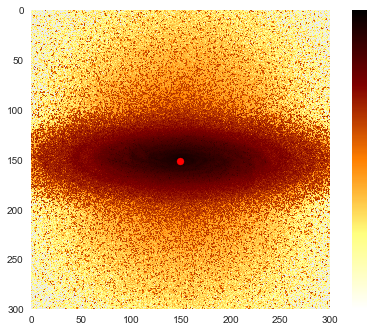

size 67 (67, 67) (300, 300) (67, 67)


<Figure size 576x396 with 0 Axes>

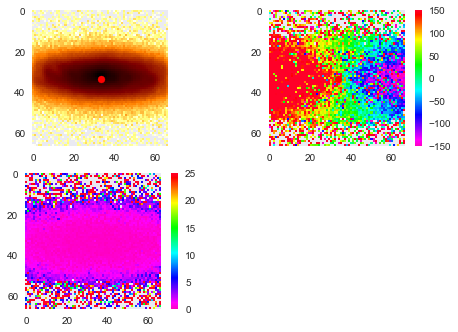

/Users/beckynevin/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


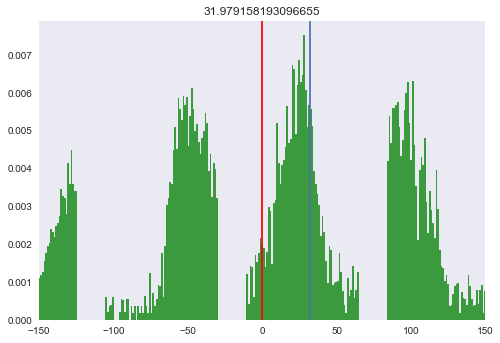

/Users/beckynevin/Documents/Backup_My_Book/My_Passport_backup/Kinematics
PA_imag -89.4
(127, 59.15568449617128)
size/2 33.5
radius in pixels 29.32784224808564
extent 4.172157751914359 62.827842248085645
diameter 58.65568449617128
difference 29.692717481451897


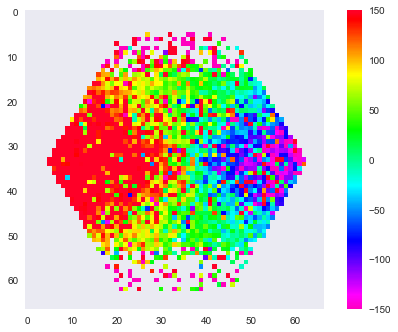

PA_kin, PA_kin_e, v_asym, s_asym -67.8286 0.0177266 0.31463486 0.11944462 0.33654436910185265 0.33654437
PA_img -89.4
resids 8.09


<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

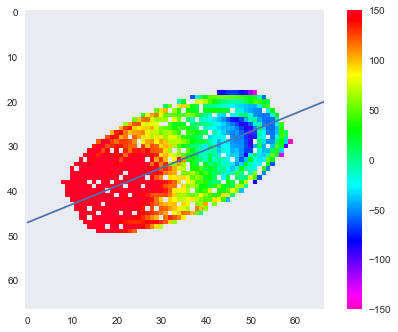

PA_kin CCW from north 112.1714
PA_img CCW from north 89.4
$\delta$ PA =  -22.7714
finished


In [16]:
print(os.getcwd())

os.chdir(os.path.expanduser('/Users/beckynevin/Documents/Backup_My_Book/My_Passport_backup/Kinematics/'))

import seaborn as sns
sns.set_style("dark")

myr_list=[5,200,180,185,190,195,205,210,220,225,230,240,250,260]
#myr_list=[200]
#myr_list=[260]

view_list=[0,1,2,3,4,5,6]

myr_list=[5,200,180,185,190,195,205,210,220,225,230,240,250,260]


view_list=[2]#1
myr_list=[200]#265

gas='no'

adds='NONSCATTER_MILESHC_corrected'
run='fg3_m12_iso1'

file1=open('PCA_kin_'+str(run)+'.txt','w')

plt.clf()
counter=0
z=0.03

for i in range(len(myr_list)):
    myr=myr_list[i]
    v_offsets=[]
    for j in range(len(view_list)):
        
        view=view_list[j]
        print('myr, view', myr, view)
        print('os.get', os.getcwd())
        '''kin_cube=pyfits.open('../Kinematics/stellar_kinematics_SCATTER_MILESHC_redshifted_fg3_m12_'+str(myr)+'_'+str(view)+'.fits')#stellar_kinematic_maps_sunrise/SUNRISE/stellar_kinematics_SCATTER_'+str(myr)+'_'+str(view)+'.fits')
#kin_cube_comp=pyfits.open('stellar_kinematic_maps_sunrise/SUNRISE/stellar_kinematics_SCATTER_MILESHC_redshifted_fg3_m12_iso0.5_'+str(myr)+'_'+str(view)+'.fits')
#grid_cube=pyfits.open('stellar_kinematic_maps_sunrise/stellar_kinematics_SCATTER_'+str(myr)+'_'+str(view)+'.fits')
im = pyfits.open('q0.5_fg0.3_allrx10_sunruns/hires_kin/broadband_'+str(myr)+'.fits')
image = im['CAMERA'+str(view)+'-BROADBAND'].data
'''
        if myr==5:
            im = pyfits.open('../LAURA_Sims/broadband_maps_sunrise/broadband_z0.03_00'+str(myr)+'.fits')
        else:
            if run=='fg3_m12':
                im = pyfits.open('../LAURA_Sims/q0.5_fg0.3_allrx10_sunruns/hires_kin/broadband_'+str(myr)+'.fits')
            #im = pyfits.open('q0.5_fg0.3_allrx10_sunruns/hires_kin_early_cen1/broadband_0'+str(myr)+'.fits')
            if run=='fg3_m12_iso1':
                im = pyfits.open('../LAURA_Sims/m1_fg0.3_BT0.2_allrx10_isolated_sunruns/broadband_'+str(myr)+'.fits')
        try:
            
            kin_cube=pyfits.open('stellar_kinematics_noise_included_'+str(run)+'_'+str(myr)+'_'+str(view)+'.fits')
            #kin_cube=pyfits.open('stellar_kinematic_maps_sunrise/stellar_kinematics_NONSCATTER_'+str(myr)+'_'+str(view)+'.fits')
        
        except FileNotFoundError:
            print('STELLAR velocity map not there yet')
            continue
        image = im['CAMERA'+str(view)+'-BROADBAND'].data
        pixelscale = im['CAMERA'+str(view)+'-BROADBAND'].header['CD1_1']
        vel=kin_cube[1].data
        vel_e=kin_cube[2].data
        
        vel = ma.masked_where(abs(vel)>1000, vel)
        vel_e = ma.masked_where(abs(vel)>1000, vel_e)
        
        try:
            broadband = image[65]#[65]
        except IndexError:
            broadband = image[2]
        
        
        centers=get_center(view, myr, run, broadband, pixelscale, z)
        
        
        
        os.chdir(os.path.expanduser('/Users/beckynevin/Documents/Backup_My_Book/My_Passport_backup/Kinematics/'))
        
        print('Here is the photometric center', centers[0],centers[1])
        #center_kin=get_center_kin(view, myr, broadband)
        plt.clf()
        plt.imshow(broadband,norm=matplotlib.colors.LogNorm(), cmap='afmhot_r')
        plt.colorbar()
        plt.scatter(centers[1],centers[0],color='r')
        #plt.scatter(center_kin[1], center_kin[0], color='g')
        plt.show()
        
        
        size=np.shape(centers[4])[0]
        
        
        
        out= centers[4]
        
        print('size', size, np.shape(out), np.shape(broadband), np.shape(vel))
        #size 61 (67, 67) (300, 300) (91, 91)
        
        plt.clf()
        fig=plt.figure()
        ax1=fig.add_subplot(221)
        im1=ax1.imshow(out,norm=matplotlib.colors.LogNorm(), cmap='afmhot_r')
        ax1.scatter(np.shape(out)[0]/2, np.shape(out)[1]/2, color='r')
        #ax1.scatter(center_kin[0],center_kin[1], color='g')
        
        ax2=fig.add_subplot(222)
        im2=ax2.imshow(vel, cmap='gist_rainbow_r', vmin=-150, vmax=150)
        ax2.scatter(np.shape(out)[0]/2, np.shape(out)[1]/2, color='r')
        #ax2.scatter(center_kin[0],center_kin[1], color='g')
        plt.colorbar(im2)

        ax3=fig.add_subplot(223)
        im3=ax3.imshow(vel_e, cmap='gist_rainbow_r', vmin=0, vmax=25)#, vmin=0, vmax=15)
        plt.colorbar(im3)
        
        #vel=ma.masked_where(abs(vel)>1000, vel)
        #vel=ma.masked_where(abs(vel_e)<10, vel)
        #vel=ma.masked_where(abs(vel_e/vel)>1, vel)
        
        '''ax4=fig.add_subplot(224)
        im4=ax4.imshow(vel, cmap='gist_rainbow_r')#, vmin=-150, vmax=150)
        plt.colorbar(im4)'''

        plt.show()
        
       
        
        
        
        
        
        '''How to go about finding the minimum'''
        '''pixel_corr=np.linspace(15,60,1000)
        sorta_chi=[]
        for i in range(len(pixel_corr)):
            corr_vel=vel-pixel_corr[i]
            sorta_chi.append(np.abs(np.sum(corr_vel)))
        
        min_i=sorta_chi.index(np.min(sorta_chi))
        plt.plot(pixel_corr, sorta_chi)
        plt.scatter(pixel_corr[min_i], sorta_chi[min_i], color='red')
        plt.show()
        
        
        
        print('min',pixel_corr[min_i],np.min(np.abs(sorta_chi)))'''
        corr_vel=vel-40#pixel_corr[min_i]#was 43.85
        '''v_offsets.append(pixel_corr[min_i])
        plt.clf()
        plt.imshow(corr_vel, vmin=-50, vmax=50,cmap='RdBu')
        plt.colorbar()
        plt.show()
        continue'''
        
        
        '''ma_corr_vel = ma.masked_where(abs(corr_vel)>10, corr_vel)
        
        plt.clf()
        plt.imshow(ma_corr_vel, cmap='RdBu')
        plt.colorbar()
        plt.show()'''
        
        '''You need to quantify this in some way by summing up the pixels
        in the center perhaps'''
        
        plt.hist(corr_vel, 20, normed=1, facecolor='green', alpha=0.75)
        plt.axvline(x=np.mean(corr_vel))
        plt.axvline(x=0, color='red')
        plt.xlim([-150,150])
        plt.title(str(np.mean(corr_vel)))
        plt.show()
        
        
        



        print(os.getcwd())
        #def determine_image(view, myr):
        img_params=determine_image(view, myr)
        #print('R_e',img_params[5])
        
        pixelscale=img_params[4]
        
        
        try:
            PA_imag=img_params[0]
        except TypeError:
            continue
        inclination=img_params[3]
        print('PA_imag', PA_imag)
        #return PA_img, size_a, arcs_totes, output

        #def determine_fiber(arcs_totes, size_a):
        fiber=determine_fiber(img_params[2], img_params[1])
        #return n_fibers, dia
        print(fiber)

        #def map_to_coords(map_cube, size):
        coords=map_to_coords(kin_cube, size)
        #return x_list, y_list, vel_list, vel_e_list, sig_list, sig_e_list

        #def mask_map(size, dia):
        inside = mask_map(size,fiber[1], coords[0], coords[1], img_params[1])
        #return inside
    
        '''Somewhere in here I need a way to convert an image to points? Or can I mask the velocity map'''

        #def make_mask(size, inside, x_list, y_list, vel_list, vel_e_list, sig_list, sig_e_list, contours, xcen, ycen):
        maps=make_mask(size, fiber[1], inside, coords[0], coords[1], coords[2], coords[3], coords[4], coords[5], broadband, centers[0], centers[1], PA_imag, img_params[1], adds, pixelscale, centers[5])
        #return rotated, stel_vel_e, stel_disp, stel_disp_e, x_list_after, y_list_after, vel_list_after, vel_e_list_after, sig_list_after, sig_e_list_after
        
        
        
        #def input_kinemetry(myr, view, x_list_after, y_list_after, vel_list_after, vel_e_list_after, sig_list_after, sig_e_list_after):

        input_kinemetry(myr, view, maps[4], maps[5], maps[6], maps[7], maps[8], maps[9] , centers[0], centers[1], adds)
        
        #continue
        
        
        out_kin=read_kin_maps(out, myr, view, fiber[1], PA_imag, size, adds)
        
        #return abs(PA_img_moved-PA_kin_moved), v_asym, s_asym, K_asym, resids
        
        #make_table(myr, view, out_kin[0], out_kin[1], out_kin[2], out_kin[3], out_kin[4], i, j)
        continue
        radon_transform(corr_vel)
        STOP
        '''Now making the output table for LDA'''
        
        if i==0 and j==0:
            file1.write('Counter'+'\t'+'Myr'+'\t'+'Viewpoint'+'\t'+'Delta PA'+'\t'+'v_asym'+'\t'+'s_asym'+'\t'+'K_tot'+'\t'+'resids'+'\t'+'i'+'\t'+'fiber'+'\n')#was str(np.shape(vel_dist)[1]-1-j)
        try:
            make_table(counter,myr, view, out_kin[0], out_kin[1], out_kin[2], out_kin[3], out_kin[4], i, j, inclination, fiber[0])
        except TypeError:
            print('skipping out')
            continue
        counter+=1
        
        
        
        #file1.close()
#print(v_offsets, np.mean(v_offsets))
file1.close()
print('finished')

In [ ]:
print('done')

In [7]:
#Uses same segmap to mask the hexagon

[(0, 107), (0, 106), (1, 105), (1, 104), (1, 103), (1, 102), (2, 101), (2, 100), (2, 99), (2, 98), (3, 97), (3, 96), (3, 95), (3, 94), (4, 93), (4, 92), (4, 91), (4, 90), (5, 89), (5, 88), (5, 87), (5, 86), (6, 85), (6, 84), (6, 83), (6, 82), (7, 81), (7, 80), (7, 79), (8, 78), (8, 77), (8, 76), (8, 75), (9, 74), (9, 73), (9, 72), (9, 71), (10, 70), (10, 69), (10, 68), (10, 67), (11, 66), (11, 65), (11, 64), (11, 63), (12, 62), (12, 61), (12, 60), (12, 59), (13, 58), (13, 57), (13, 56), (14, 55), (14, 54), (14, 53), (14, 52), (15, 51), (15, 50), (15, 49), (15, 48), (16, 47), (16, 46), (16, 45), (16, 44), (17, 43), (17, 42), (17, 41), (17, 40), (18, 39), (18, 38), (18, 37), (18, 36), (19, 35), (19, 34), (19, 33), (19, 32), (20, 31), (20, 30), (20, 29), (21, 28), (21, 27), (21, 26), (21, 25), (22, 24), (22, 23), (22, 22), (22, 21), (23, 20), (23, 19), (23, 18), (23, 17), (24, 16), (24, 15), (24, 14), (24, 13), (25, 12), (25, 11), (25, 10), (25, 9), (26, 8), (26, 7), (26, 6), (26, 5), (27

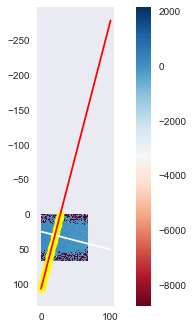

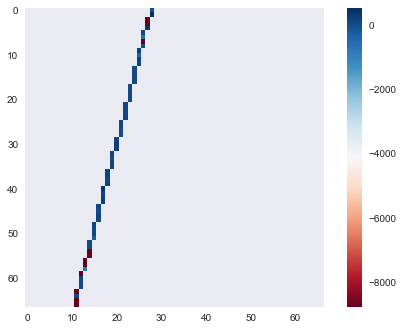

-92241.14995511665
[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]
[-8771.81916505 -8771.81916505    21.63454515 -8771.81916505
    45.37310793    10.51484561    98.89523036 -8771.81916505
  -766.32997017 -8771.81916505 -8771.81916505 -8771.81916505
 -8771.81916505    79.67433175    34.88300628  -227.16357161
    59.7471457     89.88560188   131.33199875    90.89254452
   141.25166286    62.11370938    96.26485708   275.69822387
   194.41419403   147.19633705   430.36732981   179.21076648
    80.9391485    164.96221802   141.46728097   181.24497253
   107.10465321    39.70503647   174.09526062   189.21191176
   286.59975614   121.85021965   -27.48359663    42.07745652
   111.17485621    86.07922118   121.62884368    98.66037056
    50.45741788    79.79108739    94.96448841    46.64541448
    60.06157638    49.86429054    73.31525833    71.09052017
    25.86601771    29.22086996  

In [61]:
from bresenham import bresenham
'''For every point on the map, determine the equation of a line perpendicular'''
y_in = 30
x_in = 20
plt.clf()
im1=plt.imshow(corr_vel, cmap='RdBu')
vel_field=corr_vel
plt.scatter(x_in, y_in, color='red')
deltay = y_in - np.shape(vel_field)[1]/2
deltax = x_in - np.shape(vel_field)[0]/2
slope = deltay/deltax
intercept = y_in - slope*x_in
xs = np.linspace(0, 100, 100)
ys = [slope*x+intercept for x in xs]
plt.plot(xs, ys, color='white')
plt.colorbar(im1)

'''Now draw a line perpendicular to this'''
slope_p = -deltax/deltay
intercept_p = y_in - slope_p*x_in
xs = np.linspace(0, 100, 100)
ys = [slope_p*x+intercept_p for x in xs]
plt.plot(xs, ys, color='red')


bres_list = list(bresenham(int(xs[0]),int(ys[0]),int(xs[-1]),int(ys[-1])))
print(bres_list)
vel_append=[]
vel_new=np.zeros((np.shape(vel_field)[0], np.shape(vel_field)[1]))
for j in range(len(bres_list)):
    if bres_list[j][0] < 0 or bres_list[j][1] < 0:
        continue
    plt.scatter(bres_list[j][0], bres_list[j][1], color='yellow')
    try:
        vel_append.append(vel_field[bres_list[j][1], bres_list[j][0]])
        vel_new[bres_list[j][1], bres_list[j][0]] = vel_field[bres_list[j][1], bres_list[j][0]]
    except IndexError:
        continue
plt.show()

vel_new=ma.masked_where(np.isnan(vel_new), vel_new)
vel_new = ma.masked_where(vel_new==0, vel_new)
plt.imshow(vel_new, cmap='RdBu')
plt.colorbar()
plt.show()
print(np.sum(vel_new))
print(vel_new)

vel_append=ma.masked_where(np.isnan(vel_append), vel_append)
print(vel_append, np.sum(vel_append))



In [64]:
print('starting')

'''Okay so how do you do this for very p and theta value?'''
'''p must extend to the outermost spot'''
print(np.shape(vel_field))
#center is at np.shape(vel_field)[0]/2, so p also equals this
p_list = np.linspace(-int(np.shape(vel_field)[0]/2),int(np.shape(vel_field)[0]/2), int(np.shape(vel_field)[0]/2)+1)#was 5
p_list = np.linspace(-int(np.shape(vel_field)[0]/2), int(np.shape(vel_field)[0]/2),10)#was 20
#p_list=[0]
theta_list = np.linspace(0, 180, 10)#was 10
#theta_list = [45+90+90]
print(theta_list)
'''Now I need to put this back into carteisan coordinates'''
plt.clf()


#import progressbar as pb
#widgets = ['Time for loop of x iterations: ', pb.Percentage(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ', pb.ETA()]

#timer=pb.ProgressBar( maxval=len(p_list)).start()#widgets=widgets,
#pt = progress_timer(description = 'For Loop example', n_iter = len(p_list))


A_list=[]
A_1_list=[]
A_2_list=[]

import enlighten

manager = enlighten.get_manager()
pbar = manager.counter(total=len(p_list), desc="Checking status", unit='members')
plt.imshow(vel_field, cmap='jet')
plt.colorbar()

box_list=[(0,0),
          (-1,-1),(0,-1),(1,-1),
         (-1,0),(1,0),
         (-1,1),(0,1),(1,1)]
box_list=[(0,0),
          (-3,-3),(-2,-3),(-1,-3),(0,-3),(1,-3),(2,-3),(3,-3),
         (-3,-2),(-2,-2),(-1,-2),(0,-2),(1,-2),(2,-2),(3,-2),
         (-3,-1),(-2,-1),(-1,-1),(0,-1),(1,-1),(2,-1),(3,-1),
         (-3,0),(-2,0),(-1,0),(1,0),(2,0),(3,0),
         (-3,1),(-2,1),(-1,1),(0,1),(1,1),(2,1),(3,1),
         (-3,2),(-2,2),(-1,2),(0,2),(1,2),(2,2),(3,2),
         (-3,3),(-2,3),(-1,3),(0,3),(1,3),(2,3),(3,3)]
box_list=list(ndim_grid([-7, -7],[8,8]))
print('len box_list', len(box_list))

for b in range(len(box_list)):
    
    R=[]
    R_A=[]
    R_AB=[]
    for i in range(len(p_list)):
        for j in range(len(theta_list)):
            
            X = int(p_list[i]*math.cos(math.radians(theta_list[j]))+np.shape(vel_field)[0]/2-10+box_list[b][0])
            Y = int(p_list[i]*math.sin(math.radians(theta_list[j]))+np.shape(vel_field)[1]/2-10+box_list[b][1])
            #print(b, 'X and Y', X, Y)
            
            '''We have an X and a Y and a theta (slope) so we should be able to get the intercept'''
            '''And then two more points on either end'''
            #print('input place p theta', p_list[i], theta_list[j])
            #print('input place X Y', X, Y)

            '''But we only want to calculate for things that are on the circle'''
            try:
                if np.isnan(vel_field[X,Y]):

                    continue
            except IndexError:
                print('trying to feed these indices', X, Y)
                STOP

            else:
                #plt.imshow(vel_field, cmap='RdBu')
                #plt.colorbar()
                #plt.show()

                #plt.scatter(X,Y)
                plt.scatter(np.shape(vel_field)[0]/2, np.shape(vel_field)[1]/2, color='orange')
                deltay = Y - np.shape(vel_field)[1]/2
                deltax = X - np.shape(vel_field)[0]/2


                '''Now draw a line perpendicular to this'''
                slope_p = math.tan(math.radians(theta_list[j]+90))#-deltax/deltay
                #print('slope', theta_list[j],math.tan(math.radians(theta_list[j])))
                #print('slope_p', slope_p)

                intercept = Y - slope_p*X



                if slope_p > 1000:
                    x_min = X
                    x_max = X
                    y_min = 0
                    y_max = np.shape(vel_field)[0]
                else:
                    x_min = 0
                    x_max = np.shape(vel_field)[0]
                    y_min = intercept
                    y_max = intercept+slope_p*x_max

                bres_line = list(bresenham(int(x_min), int(y_min), int(x_max), int(y_max)))

                #print(bres_line)
                bres_line_new=[]
                for k in range(len(bres_line)):
                    '''print(bres_line[k][1])
                    STOP'''
                    if bres_line[k][1] < 0 or bres_line[k][1]>np.shape(vel_field)[1]:
                        continue
                    else:
                        bres_line_new.append(bres_line[k])

                bres_list=bres_line_new


                vel_append=[]
                #vel_new=np.zeros((np.shape(vel_field)[0], np.shape(vel_field)[1]))
                for k in range(len(bres_list)):
                    if bres_list[k][0] < 0 or bres_list[k][1] < 0:
                        continue
                    #plt.scatter(bres_list[k][0], bres_list[k][1], color='yellow')

                    try:
                        #print('now going to append', vel_field[bres_list[j][1], bres_list[j][0]])

                        vel_append.append(vel_field[bres_list[k][1], bres_list[k][0]])
                        #vel_new[bres_list[j][1], bres_list[j][0]] = vel_field[bres_list[j][1], bres_list[j][0]]
                    except IndexError:
                        continue

                plt.scatter(X,Y, color='red') 
                vel_append_clean=[]
                for k in range(len(vel_append)):
                    if ma.is_masked(vel_append[k]):
                        continue
                    else:
                        vel_append_clean.append(vel_append[k])
                    #    del vel_append[j]


                #print(vel_append, np.sum(vel_append))
                R.append(np.sum(vel_append_clean))

                '''R_A is the same but the abs valueof the difference with the mean of each seg'''
                inside=vel_append_clean-np.mean(vel_append_clean)
                R_A.append(np.sum(np.abs(inside)))



                '''R_AB is integrated over a smaller length'''
                vel_append=[]
                for k in range(len(bres_list)):
                    if bres_list[k][0] < 0 or bres_list[k][1] < 0:
                        continue
                    if np.sqrt((bres_list[k][0]-X)**2+(bres_list[k][1]-Y)**2) > 37:
                        continue
                    #plt.scatter(bres_list[j][0], bres_list[j][1], color='yellow')
                    try:
                        vel_append.append(vel_field[bres_list[k][1], bres_list[k][0]])
                        #vel_new[bres_list[j][1], bres_list[j][0]] = vel_field[bres_list[j][1], bres_list[j][0]]
                    except IndexError:
                        continue

                vel_append_clean=[]
                for k in range(len(vel_append)):
                    if ma.is_masked(vel_append[k]):
                        continue
                    else:
                        vel_append_clean.append(vel_append[k])


                #plt.xlim([0,100])
                #plt.ylim([100,0])
                #plt.show()


                #vel_new=ma.masked_where(np.isnan(vel_new), vel_new)
                #vel_new = ma.masked_where(vel_new==0, vel_new)
                '''plt.imshow(vel_new, cmap='RdBu')
                plt.colorbar()
                plt.xlim([0,100])
                plt.ylim([100,0])
                plt.show()'''

                '''R_AB is the same but the abs valueof the difference with the mean of each seg'''
                if vel_append_clean:


                    inside=vel_append_clean-np.mean(vel_append_clean)
                    R_AB.append(np.sum(np.abs(inside)))
                else:
                    R_AB.append(-1000)

    #print('done with the boxing')
    
    '''Now make the theta hat thing'''
    R=ma.masked_where(np.isnan(R), R)
    R_A=ma.masked_where(np.isnan(R_A), R_A)
    R_AB=ma.masked_where(np.isnan(R_AB), R_AB)
    R_AB = ma.masked_where(R_AB==-1000, R_AB)

    R_AB_array = np.reshape(R_AB, (len(p_list),len(theta_list)))
    #print(np.shape(R_AB_array), np.shape(p_list))

    theta_hat=[]
    theta_hat_e=[]

    for l in range(len(p_list)):

        marginalized = R_AB_array[l,:]
        #print(type(marginalized))
        #print(marginalized)

        if ma.is_masked(marginalized)==True:
            theta_hat.append(0)
            theta_hat_e.append(0)
            continue




        '''plt.clf()
        plt.scatter(theta_list, marginalized)'''


        def gauss(x,a,x0,sigma):
            return a*exp(-(x-x0)**2/(2*sigma**2))
        from scipy.optimize import curve_fit
        from scipy import asarray as ar,exp

        try:
            popt,pcov = curve_fit(gauss,theta_list,marginalized,p0=[1,theta_list[list(marginalized).index(max(marginalized))],20])
        except RuntimeError:
            theta_hat.append(0)
            theta_hat_e.append(0)
            continue
        '''plt.plot(theta_list, gauss(theta_list,popt[0],popt[1],popt[2]))
        plt.show()'''

        theta_hat.append(popt[1])
        theta_hat_e.append(pcov[1][1])
    '''plt.clf()
    #print('theta hat before mask', theta_hat)
    #theta_hat = np.array(theta_hat)
    #theta_hat=ma.masked_where(theta_hat<0, theta_hat)
    #theta_hat_e=ma.masked_where(theta_hat<0, theta_hat_e)
    #print('theta hat after mask', theta_hat)
    plt.scatter(p_list,theta_hat )
    plt.errorbar(p_list,theta_hat, yerr=theta_hat_e)
    plt.show()'''

    #p_list_masked=ma.masked_where(theta_hat < 0, p_list)
    #print(p_list)

    #print(p_list[0:int(len(p_list)/2)])

    delta_theta_sum=[]
    delta_theta_sum_e=[]
    for l in range(int(len(p_list)/2)):
        delta_theta_sum.append(abs(theta_hat[0+l]+theta_hat[-1-l]))
        delta_theta_sum_e.append(np.sqrt(theta_hat_e[0+l]**2+theta_hat_e[-1-l]**2))
    
    delta_theta_sum_masked=ma.masked_where(np.array(delta_theta_sum)==0, delta_theta_sum)
    if b==0:
        OG_weight=ma.count(delta_theta_sum_masked)*2

    A = (ma.sum(delta_theta_sum)/(3*ma.count(delta_theta_sum_masked)*2))*OG_weight
    #print(A)
    A_list.append(A)

    '''Also calculate the other types of asymmetry'''
    delta_theta_sum=ma.masked_where(np.array(delta_theta_sum)==0, delta_theta_sum)
    delta_theta_sum_e=ma.masked_where(np.array(delta_theta_sum_e)==0, delta_theta_sum_e)

    #print('delta_theta_sum', delta_theta_sum)
    #print('delta_theta_sum_e', delta_theta_sum_e)
    A_2 = ma.sum(delta_theta_sum/delta_theta_sum_e)

    A_1 = (1/(max(theta_hat)-min(theta_hat)))*(np.sum(delta_theta_sum/delta_theta_sum_e**2))*(1/np.sum(1/delta_theta_sum_e**2))

    A_1_list.append(A_1)
    A_2_list.append(A_2)

    
print('A list',A_list)

starting
(67, 67)
[  0.  20.  40.  60.  80. 100. 120. 140. 160. 180.]
len box_list 225


/Users/beckynevin/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/beckynevin/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:273: RuntimeWarning: invalid value encountered in long_scalars


ZeroDivisionError: division by zero

In [167]:
print((A_list).index(min(A_list)))
print(box_list[(A_list).index(min(A_list))], min(A_list))

106
[ 0 -6] 79.39607422321306


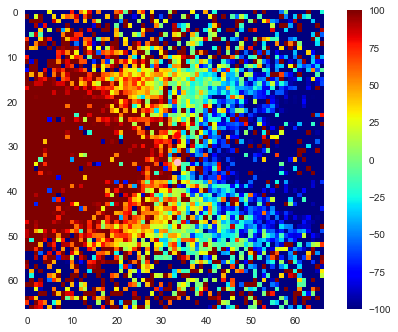

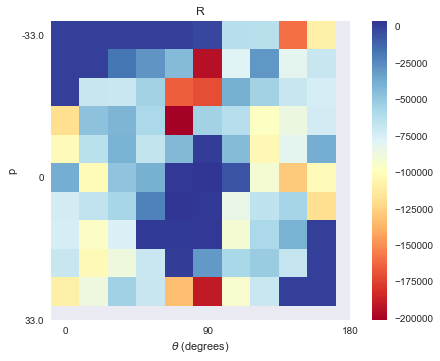

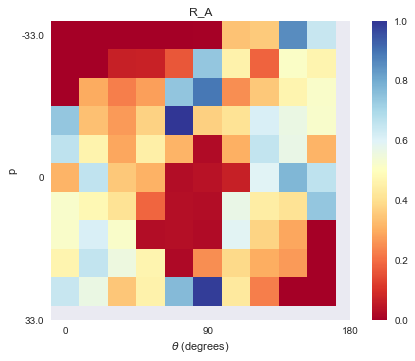

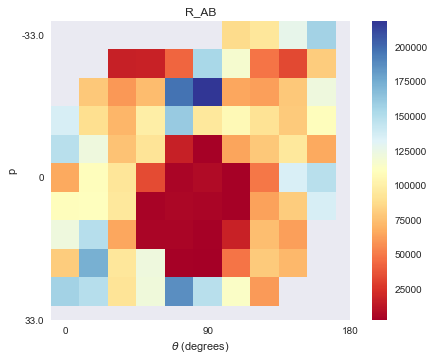

(10, 10) (10,)
<class 'numpy.ma.core.MaskedArray'>
[-- -- -- -- -- -- 87898.97841098942 94420.75025443477 127442.76102231375
 156758.87757772492]
<class 'numpy.ma.core.MaskedArray'>
[-- -- 17668.108714369137 18732.883432770363 44083.90875337616
 154274.948442809 117364.70600672996 48788.65799336665 33462.745991223586
 80512.46138632607]
<class 'numpy.ma.core.MaskedArray'>
[-- 79198.15110870895 60541.782864249755 73914.56231850325
 197081.45624669563 218976.9115224586 65805.19207025356 62967.31417082426
 79485.85667282193 122665.43512553225]
<class 'numpy.ma.core.MaskedArray'>
[135776.92214463552 89506.35590912007 71760.0579292402 99367.30432081441
 161158.72166676816 95431.5085158585 107334.38201575623 91435.93161945682
 80036.55274720232 109956.77816758452]
<class 'numpy.ma.core.MaskedArray'>
[148833.5917722684 122436.59080517414 76919.1085650483 92732.29071365819
 17320.19574410793 3947.094950475479 64917.01461534015 79474.26668820847
 95059.84738279975 66397.80675449283]
<class 'num

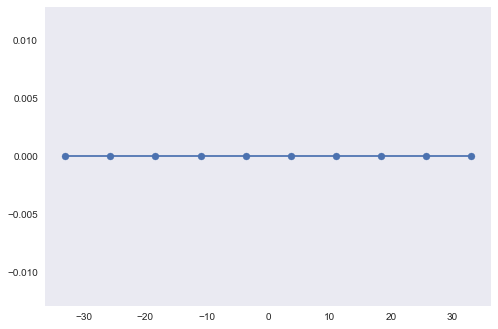

[-33.         -25.66666667 -18.33333333 -11.          -3.66666667
   3.66666667  11.          18.33333333  25.66666667  33.        ]
[-33.         -25.66666667 -18.33333333 -11.          -3.66666667]
[0, 0, 0, 0, 0]
0
[-- -- -- -- --]
8 0
nan
delta_theta_sum [-- -- -- -- --]
delta_theta_sum_e [-- -- -- -- --]


/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:135: RuntimeWarning: invalid value encountered in long_scalars


ZeroDivisionError: division by zero

In [67]:
R=ma.masked_where(np.isnan(R), R)
R_A=ma.masked_where(np.isnan(R_A), R_A)
R_AB=ma.masked_where(np.isnan(R_AB), R_AB)

#print(np.shape(R))
#print(np.reshape(R, (len(p_list),len(theta_list))))

X, Y = np.meshgrid(theta_list, p_list)
#print(np.shape(X))
plt.clf()
im1=plt.imshow(vel_field, cmap='jet', vmin=-100, vmax=100)
plt.scatter(np.shape(vel_field)[0]/2, np.shape(vel_field)[1]/2, color='pink')
plt.scatter(np.shape(vel_field)[0]/2, np.shape(vel_field)[1]/2-6, color='red')
plt.colorbar(im1)
plt.show()



#print(p_list)
#print(theta_list)



plt.imshow(np.reshape(R, (len(p_list),len(theta_list))), cmap='RdYlBu')
plt.colorbar()
plt.xticks([0,len(theta_list)/2,len(theta_list)], [0,90,180])
plt.yticks([0, len(p_list)/2, len(p_list)], [p_list[0],0, p_list[-1]])
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'p')
plt.title('R')
plt.show()






plt.imshow(np.reshape(R_A, (len(p_list),len(theta_list)))/np.max(R_A), cmap='RdYlBu')
plt.colorbar()
plt.xticks([0,len(theta_list)/2,len(theta_list)], [0,90,180])
plt.yticks([0, len(p_list)/2, len(p_list)], [p_list[0],0, p_list[-1]])
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'p')
plt.title('R_A')
plt.show()

'''plt.plot(theta_list, R_A)
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'R$_{\mathrm{A}}$')
plt.annotate(r'Global PA$_{\mathrm{k}}$ = '+str(round(theta_list[list(R_A).index(max(R_A))],1)),
            xy=(0.1,0.8),xycoords='axes fraction', size=20)
plt.axvline(x=theta_list[list(R_A).index(max(R_A))])
plt.show()'''


R_AB = ma.masked_where(R_AB==-1000, R_AB)
plt.imshow(np.reshape(R_AB, (len(p_list),len(theta_list))), cmap='RdYlBu')#/np.max(R_AB)
plt.colorbar()
plt.xticks([0,len(theta_list)/2,len(theta_list)], [0,90,180])
plt.yticks([0, len(p_list)/2, len(p_list)], [p_list[0],0, p_list[-1]])
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'p')
plt.title('R_AB')
plt.show()

'''Now make the theta hat thing'''
R_AB_array = np.reshape(R_AB, (len(p_list),len(theta_list)))
print(np.shape(R_AB_array), np.shape(p_list))

theta_hat=[]
theta_hat_e=[]

for l in range(len(p_list)):

    marginalized = R_AB_array[l,:]
    print(type(marginalized))
    print(marginalized)
    
    if ma.is_masked(marginalized)==True:
        theta_hat.append(0)
        theta_hat_e.append(0)
        continue
        


    
    plt.clf()
    plt.scatter(theta_list, marginalized)


    def gauss(x,a,x0,sigma):
        return a*exp(-(x-x0)**2/(2*sigma**2))
    from scipy.optimize import curve_fit
    from scipy import asarray as ar,exp

    try:
        popt,pcov = curve_fit(gauss,theta_list,marginalized,p0=[1,theta_list[list(marginalized).index(max(marginalized))],20])
    except RuntimeError:
        theta_hat.append(0)
        theta_hat_e.append(0)
        continue
    plt.plot(theta_list, gauss(theta_list,popt[0],popt[1],popt[2]))
    plt.show()

    theta_hat.append(popt[1])
    theta_hat_e.append(pcov[1][1])
plt.clf()
#print('theta hat before mask', theta_hat)
#theta_hat = np.array(theta_hat)
#theta_hat=ma.masked_where(theta_hat<0, theta_hat)
#theta_hat_e=ma.masked_where(theta_hat<0, theta_hat_e)
#print('theta hat after mask', theta_hat)
plt.scatter(p_list,theta_hat )
plt.errorbar(p_list,theta_hat, yerr=theta_hat_e)
plt.show()

#p_list_masked=ma.masked_where(theta_hat < 0, p_list)
print(p_list)

print(p_list[0:int(len(p_list)/2)])

delta_theta_sum=[]
delta_theta_sum_e=[]
for l in range(int(len(p_list)/2)):
    delta_theta_sum.append(abs(theta_hat[0+l]+theta_hat[-1-l]))
    delta_theta_sum_e.append(np.sqrt(theta_hat_e[0+l]**2+theta_hat_e[-1-l]**2))
print(delta_theta_sum)

print(ma.sum((delta_theta_sum)))
delta_theta_sum_masked=ma.masked_where(np.array(delta_theta_sum)==0, delta_theta_sum)
print(delta_theta_sum_masked)
print('8', ma.count(delta_theta_sum_masked)*2)
OG_weight=8

A = (ma.sum(delta_theta_sum)/(3*ma.count(delta_theta_sum_masked)*2))*OG_weight
print(A)

'''Also calculate the other types of asymmetry'''
delta_theta_sum=ma.masked_where(np.array(delta_theta_sum)==0, delta_theta_sum)
delta_theta_sum_e=ma.masked_where(np.array(delta_theta_sum_e)==0, delta_theta_sum_e)

print('delta_theta_sum', delta_theta_sum)
print('delta_theta_sum_e', delta_theta_sum_e)
A_2 = ma.sum(delta_theta_sum/delta_theta_sum_e)

A_1 = (1/(max(theta_hat)-min(theta_hat)))*(np.sum(delta_theta_sum/delta_theta_sum_e**2))*(1/np.sum(1/delta_theta_sum_e**2))

print('overall range', max(theta_hat)-min(theta_hat))
print('A_1', A_1)
print('A_2', A_2)

'''At each value of rho you have to estimate the optimal theta'''

'''then fip over rho = 0 and calculate the asymmetry for this choice of the center'''
'''Match negative rhos to positive ones of the same value'''


'''plt.plot(theta_list, R_AB)
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'R$_{\mathrm{AB}}$')
plt.annotate(r'Global PA$_{\mathrm{k}}$ = '+str(round(theta_list[list(R_AB).index(max(R_AB))],1)),
            xy=(0.1,0.8),xycoords='axes fraction', size=20)
plt.axvline(x=theta_list[list(R_AB).index(max(R_AB))])
plt.show()'''



In [121]:
#p_list_masked=ma.masked_where(theta_hat < 0, p_list)
print(p_list)

print(p_list[0:int(len(p_list)/2)])

delta_theta_sum=[]
for l in range(int(len(p_list)/2)):
    delta_theta_sum.append(abs(theta_hat[0+l]+theta_hat[-1-l]))

print(delta_theta_sum)

print(ma.sum((delta_theta_sum)))
delta_theta_sum_masked=ma.masked_where(np.array(delta_theta_sum)==0, delta_theta_sum)
print(delta_theta_sum_masked)
print('8', ma.count(delta_theta_sum_masked)*2)
OG_weight=8

A = (ma.sum(delta_theta_sum)/(3*ma.count(delta_theta_sum_masked)*2))*OG_weight
print(A)

[-45.         -40.26315789 -35.52631579 -30.78947368 -26.05263158
 -21.31578947 -16.57894737 -11.84210526  -7.10526316  -2.36842105
   2.36842105   7.10526316  11.84210526  16.57894737  21.31578947
  26.05263158  30.78947368  35.52631579  40.26315789  45.        ]
[-45.         -40.26315789 -35.52631579 -30.78947368 -26.05263158
 -21.31578947 -16.57894737 -11.84210526  -7.10526316  -2.36842105]
[0, 0, 0, 0, 0, 0, 175.83357177889866, 182.24160733840856, 179.78709709823647, 180.0236950040134]
717.8859712195572
[-- -- -- -- -- -- 175.83357177889866 182.24160733840856
 179.78709709823647 180.0236950040134]
8 8
239.2953237398524


In [81]:
print(len(p_list), len(theta_hat))

20 32


In [138]:
box_list=[(0,0),
          (-3,-3),(-2,-3),(-1,-3),(0,-3),(1,-3),(2,-3),(3,-3),
         (-3,-2),(-2,-2),(-1,-2),(0,-2),(1,-2),(2,-2),(3,-2),
         (-3,-1),(-2,-1),(-1,-1),(0,-1),(1,-1),(2,-1),(3,-1),
         (-3,0),(-2,0),(-1,0),(1,0),(2,0),(3,0),
         (-3,1),(-2,1),(-1,1),(0,1),(1,1),(2,1),(3,1),
         (-3,2),(-2,2),(-1,2),(0,2),(1,2),(2,2),(3,2),
         (-3,3),(-2,3),(-1,3),(0,3),(1,3),(2,3),(3,3)]
print(np.shape(box_list))


box_list=[(0,0),
          (-1,-1),(0,-1),(1,-1),
         (-1,0),(1,0),
         (-1,1),(0,1),(1,1)]

(9, 2)


In [63]:
def ndim_grid(start,stop):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.arange(start[i],stop[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [159]:
list(ndim_grid([-4, -4],[5,5]))

array([[-4, -4],
       [-4, -3],
       [-4, -2],
       [-4, -1],
       [-4,  0],
       [-4,  1],
       [-4,  2],
       [-4,  3],
       [-4,  4],
       [-3, -4],
       [-3, -3],
       [-3, -2],
       [-3, -1],
       [-3,  0],
       [-3,  1],
       [-3,  2],
       [-3,  3],
       [-3,  4],
       [-2, -4],
       [-2, -3],
       [-2, -2],
       [-2, -1],
       [-2,  0],
       [-2,  1],
       [-2,  2],
       [-2,  3],
       [-2,  4],
       [-1, -4],
       [-1, -3],
       [-1, -2],
       [-1, -1],
       [-1,  0],
       [-1,  1],
       [-1,  2],
       [-1,  3],
       [-1,  4],
       [ 0, -4],
       [ 0, -3],
       [ 0, -2],
       [ 0, -1],
       [ 0,  0],
       [ 0,  1],
       [ 0,  2],
       [ 0,  3],
       [ 0,  4],
       [ 1, -4],
       [ 1, -3],
       [ 1, -2],
       [ 1, -1],
       [ 1,  0],
       [ 1,  1],
       [ 1,  2],
       [ 1,  3],
       [ 1,  4],
       [ 2, -4],
       [ 2, -3],
       [ 2, -2],
       [ 2, -1],
       [ 2,  0